College admission: https://www.kaggle.com/datasets/sumithbhongale/american-university-data-ipeds-dataset

**Research ideas:**

- what social, economic, and regional factors affect admission rate at undergraduate institutions?
- do more expensive colleges actually breed more successful students? - could not do because didn't really have data on success of students

Opportunities for error / misinterpretation:
- each state / region has a lot of colleges with different acceptance rates
- non-normalized number of observations per category, may skew data
- non linear relationship between tuition and admission rate, couldn't find a fix

Recommendations:
- collect % in state vs out state students
- % first-generation students (technically had data, was just missing)
- avg income of parents/caregivers
- avg test scores

# Read in data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import math
import numpy as np

In [3]:
# read in data
df = pd.read_excel("./IPEDS_data.xlsx")

In [4]:
# list all cols
list(df.columns)

['ID number',
 'Name',
 'year',
 'ZIP code',
 'Highest degree offered',
 'County name',
 'Longitude location of institution',
 'Latitude location of institution',
 'Religious affiliation',
 'Offers Less than one year certificate',
 'Offers One but less than two years certificate',
 "Offers Associate's degree",
 'Offers Two but less than 4 years certificate',
 "Offers Bachelor's degree",
 'Offers Postbaccalaureate certificate',
 "Offers Master's degree",
 "Offers Post-master's certificate",
 "Offers Doctor's degree - research/scholarship",
 "Offers Doctor's degree - professional practice",
 "Offers Doctor's degree - other",
 'Offers Other degree',
 'Applicants total',
 'Admissions total',
 'Enrolled total',
 'Percent of freshmen submitting SAT scores',
 'Percent of freshmen submitting ACT scores',
 'SAT Critical Reading 25th percentile score',
 'SAT Critical Reading 75th percentile score',
 'SAT Math 25th percentile score',
 'SAT Math 75th percentile score',
 'SAT Writing 25th percentil

# Data cleaning

In [5]:
# explore diff columns and their values
df.Name.value_counts()

Westminster College                              3
Union College                                    3
Columbia College                                 2
University of St Thomas                          2
Bethel University                                2
                                                ..
University of Maryland-College Park              1
University of Maryland-Baltimore County          1
University of Maryland-University College        1
Loyola University Maryland                       1
Polytechnic University of Puerto Rico-Orlando    1
Name: Name, Length: 1517, dtype: int64

In [6]:
# why are there multiple entries of the same college?
# oh they just have the same name, but they're in different locations
df[df.Name == "Bethel University"]

ID number               Name  year ZIP code  \
624      173160  Bethel University  2013    55112   
1225     219718  Bethel University  2013    38201   

                      Highest degree offered     County name  \
624   Doctor's degree - research/scholarship   Ramsey County   
1225                         Master's degree  Carroll County   

      Longitude location of institution  Latitude location of institution  \
624                          -93.159295                         45.057091   
1225                         -88.516162                         36.139271   

        Religious affiliation Offers Less than one year certificate  ...  \
624                   Baptist                                   Yes  ...   
1225  Cumberland Presbyterian                            Implied no  ...   

     Percent of freshmen  receiving federal grant aid  \
624                                              28.0   
1225                                             76.0   

     Percent of freshmen receiving Pell grants  \
624                                       25.0   
1225                                      76.0   

     Percent of freshmen receiving other federal grant aid  \
624                                                 6.0      
1225                                               29.0      

     Percent of freshmen receiving state/local grant aid  \
624                                                30.0    
1225                                               32.0    

     Percent of freshmen receiving institutional grant aid  \
624                                               100.0      
1225                                               45.0      

     Percent of freshmen receiving student loan aid  \
624                                            70.0   
1225                                           84.0   

     Percent of freshmen receiving federal student loans  \
624                                                69.0    
1225                                               84.0    

     Percent of freshmen receiving other loan aid  \
624                                          18.0   
1225                                          0.0   

     Endowment assets (year end) per FTE enrollment (GASB)  \
624                                                 NaN      
1225                                                NaN      

     Endowment assets (year end) per FTE enrollment (FASB)  
624                                              6617.0     
1225                                              518.0     

[2 rows x 145 columns]

In [7]:
# should we just study undergrad data?
df["Offers Bachelor's degree"].value_counts()

Yes           1522
Implied no      10
Name: Offers Bachelor's degree, dtype: int64

In [8]:
# how many colleges offer bachelors degree = 1522 out of 1534
# there seem to be enough -- drop non-undergrad institutions
df = df[df["Offers Bachelor's degree"] == "Yes"]

In [9]:
# drop na in response (admission rate column)
df = df[~df["Percent admitted - total"].isna()]

In [10]:
# add region column
west = ["Washington","Oregon","California","Alaska","Idaho","Montana",
        "Wyoming","Nevada","Utah","Colorado","Arizona","New Mexico",
       "Hawaii"]
midwest = ["North Dakota", "South Dakota", "Nebraska","Kansas",
          "Minnesota","Iowa","Missouri","Wisconsin","Illinois",
          "Michigan","Indiana","Ohio"]
northeast = ["Maine","Vermont","New Hampshire","Massachusetts",
            "Connecticut","Rhode Island","New York","Pennsylvania",
            "New Jersey"]
south = ["Texas","Oklahoma","Arkansas","Louisiana","Mississippi",
        "Kentucky","Tennessee","Alabama","West Virginia","Virginia",
        "North Carolina","South Carolina","Georgia","Florida",
        "District of Columbia","Delaware","Maryland"]

def region(row):
    if row in west:
        return "West"
    elif row in midwest:
        return "Midwest"
    elif row in northeast:
        return "Northeast"
    else:
        return "South"
    
df["Region"] = df["State abbreviation"].apply(region)

In [11]:
# fix bool columns - turn into dummy variables for use in lin reg model
# edit: didn't end up using lin reg model
df[["Religious affiliation","Historically Black College or University"]]

def religious(row):
    if row == "Not applicable":
        return 0
    else:
        return 1
def hbcu(row):
    if row == "Yes":
        return 1
    else:
        return 0
def priv(row):
    if row == "Private not-for-profit":
        return 1
    else:
        return 0
    
df["Religious affiliation"] = df["Religious affiliation"].apply(religious)
df["Historically Black College or University"] = df["Historically Black College or University"].apply(hbcu)
df["Private"] = df["Control of institution"].apply(priv)

df[["Religious affiliation","Historically Black College or University","Private"]]

Religious affiliation  Historically Black College or University  Private
0                         0                                         1        0
1                         0                                         0        0
3                         0                                         0        0
4                         0                                         1        0
5                         0                                         0        0
...                     ...                                       ...      ...
1516                      1                                         0        1
1525                      0                                         0        0
1529                      0                                         0        0
1530                      1                                         0        1
1532                      1                                         0        1

[1376 rows x 3 columns]

In [12]:
# add groupings of admission rates - by tens
def nearest_ten(row):
    a = row / 10
    a = math.floor(a)
    return a * 10
df["Admission rate - tens"] = df["Percent admitted - total"].apply(nearest_ten)
df[["Admission rate - tens","Percent admitted - total"]]

Admission rate - tens  Percent admitted - total
0                        90                      90.0
1                        80                      87.0
3                        80                      81.0
4                        50                      51.0
5                        50                      57.0
...                     ...                       ...
1516                     60                      60.0
1525                     40                      44.0
1529                     30                      35.0
1530                     70                      71.0
1532                     50                      53.0

[1376 rows x 2 columns]

In [13]:
# add groupings for urbanization, clean up category names
print(df["Degree of urbanization (Urban-centric locale)"].value_counts())

def urban(row):
    return row.split(":")[0]

df["Degree of urbanization"] = df["Degree of urbanization (Urban-centric locale)"].apply(urban)

print(df["Degree of urbanization"].value_counts())

City: Large        268
Suburb: Large      259
City: Small        199
City: Midsize      167
Town: Distant      148
Town: Remote       116
Town: Fringe        56
Rural: Fringe       47
Suburb: Midsize     47
Suburb: Small       31
Rural: Distant      25
Rural: Remote       13
Name: Degree of urbanization (Urban-centric locale), dtype: int64
City      634
Suburb    337
Town      320
Rural      85
Name: Degree of urbanization, dtype: int64


In [14]:
# filter to cols to keep

# maintain list of cols to keep (drop the rest later)
cols_i_want = ['Name','Longitude location of institution',
       'Latitude location of institution', 'Region', 'Religious affiliation',
       'Applicants total', 'Admissions total', 'Enrolled total',
       'Tuition and fees, 2010-11',
       'Tuition and fees, 2011-12', 'Tuition and fees, 2012-13',
       'Tuition and fees, 2013-14',
       'Total price for in-state students living on campus 2013-14',
       'Total price for out-of-state students living on campus 2013-14',
       'Historically Black College or University',
       'Undergraduate enrollment',
       'Percent of undergraduate enrollment that are American Indian or Alaska Native',
       'Percent of undergraduate enrollment that are Asian',
       'Percent of undergraduate enrollment that are Black or African American',
       'Percent of undergraduate enrollment that are Hispanic/Latino',
       'Percent of undergraduate enrollment that are Native Hawaiian or Other Pacific Islander',
       'Percent of undergraduate enrollment that are White',
       'Percent of undergraduate enrollment that are two or more races',
       'Percent of undergraduate enrollment that are Race/ethnicity unknown',
       'Percent of undergraduate enrollment that are Nonresident Alien',
       'Percent of undergraduate enrollment that are Asian/Native Hawaiian/Pacific Islander',
       'Percent of undergraduate enrollment that are women',
       'Graduation rate - Bachelor degree within 4 years, total',
       'Graduation rate - Bachelor degree within 5 years, total',
       'Graduation rate - Bachelor degree within 6 years, total',
       'Percent of freshmen receiving any financial aid',
       'Percent admitted - total',
        "Admission rate - tens",
        "Private",
        "Degree of urbanization",
        "State abbreviation"]

df = df[cols_i_want]

In [15]:
# look at NA's
df.isna().sum(axis=0)

Name                                                                                       0
Longitude location of institution                                                          0
Latitude location of institution                                                           0
Region                                                                                     0
Religious affiliation                                                                      0
Applicants total                                                                           0
Admissions total                                                                           0
Enrolled total                                                                             0
Tuition and fees, 2010-11                                                                  4
Tuition and fees, 2011-12                                                                  4
Tuition and fees, 2012-13                                             

In [16]:
# interpolate with mean
df[["Graduation rate - Bachelor degree within 4 years, total",
   "Percent of freshmen receiving any financial aid"]].describe()

Graduation rate - Bachelor degree within 4 years, total  \
count                                        1367.000000         
mean                                           39.057791         
std                                            21.494738         
min                                             0.000000         
25%                                            22.000000         
50%                                            36.000000         
75%                                            54.000000         
max                                           100.000000         

       Percent of freshmen receiving any financial aid  
count                                      1373.000000  
mean                                         90.779315  
std                                          11.574645  
min                                          41.000000  
25%                                          87.000000  
50%                                          95.000000  
75%                                          99.000000  
max                                         100.000000

In [17]:
df["Graduation rate - Bachelor degree within 4 years, total"] = df["Graduation rate - Bachelor degree within 4 years, total"].fillna(39.057791)
df["Percent of freshmen receiving any financial aid"] = df["Percent of freshmen receiving any financial aid"].fillna(90.779315)

# EDA

In [18]:
# save categorical vars to use for plots
categ_cols = ["Name","Region","Religious affiliation","Private","Historically Black College or University",
             "Degree of urbanization", "State abbreviation"]

Dive deeper into admission rate column

In [19]:
df["Percent admitted - total"].describe()

count    1376.000000
mean       64.569767
std        18.710062
min         6.000000
25%        54.000000
50%        67.000000
75%        78.000000
max       100.000000
Name: Percent admitted - total, dtype: float64

In [20]:
# what colleges have the lowest AR?
df[df["Percent admitted - total"] == 6].Name

544      Harvard University
1469    Stanford University
Name: Name, dtype: object

In [21]:
# what colleges have the highest AR?
df[df["Percent admitted - total"] == 100].Name

15              University of West Alabama
95                      Coleman University
281              Lewis-Clark State College
283         Brigham Young University-Idaho
451                University of Pikeville
633          Metropolitan State University
709      Montana State University-Northern
799          College of Staten Island CUNY
1313    The University of Texas at El Paso
1343                       Goddard College
1385          Southern Virginia University
1479                   Brandman University
Name: Name, dtype: object

Text(0.5, 1.0, 'Distribution of Admission Rates')

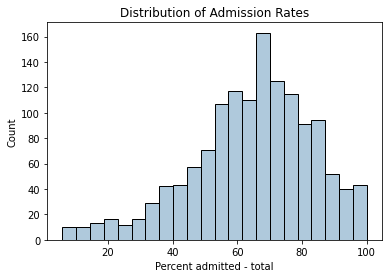

In [22]:
# hist of AR
sns.histplot(data=df, x="Percent admitted - total", color="#95b8d1")
plt.title("Distribution of Admission Rates")

Geographic distribution of colleges in data

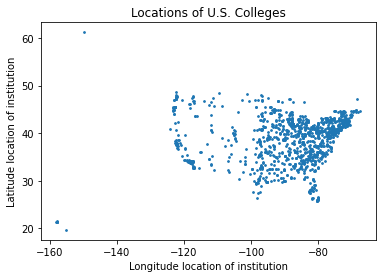

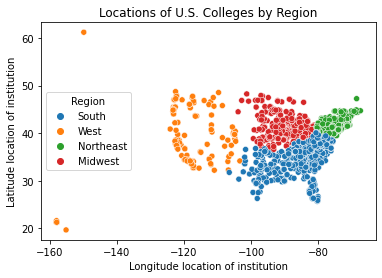

In [23]:
# distribution of undergrad universities across U.S.
df.plot(kind="scatter", x="Longitude location of institution", y="Latitude location of institution", s=3)
plt.title("Locations of U.S. Colleges")
plt.show()

# chosen by https://www.50states.com/city/regions.html
sns.scatterplot(x="Longitude location of institution", y="Latitude location of institution",
                data=df, hue="Region")
plt.title("Locations of U.S. Colleges by Region")
plt.show()
plt.show()

In [24]:
# % colleges from each region
df["Region"].value_counts()
print("south:", df["Region"].value_counts()["South"]/len(df))
print("northeast:", df["Region"].value_counts()["Northeast"]/len(df))
print("midwest:", df["Region"].value_counts()["Midwest"]/len(df))
print("west:", df["Region"].value_counts()["West"]/len(df))

south: 0.34084302325581395
northeast: 0.27325581395348836
midwest: 0.2558139534883721
west: 0.1300872093023256


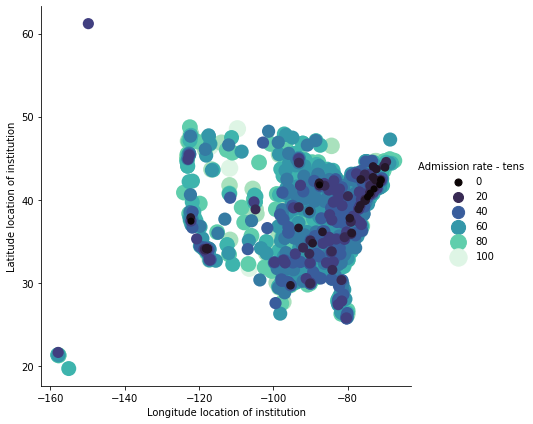

In [25]:
# show AR across geography
sns.relplot(x="Longitude location of institution", y="Latitude location of institution", hue="Admission rate - tens",
            size="Admission rate - tens",
            sizes=(50, 300), palette="mako",
            height=6, edgecolor="none",data=df.sort_values(["Admission rate - tens"], ascending=False))




How does average AR vary across different college types / breakdowns?

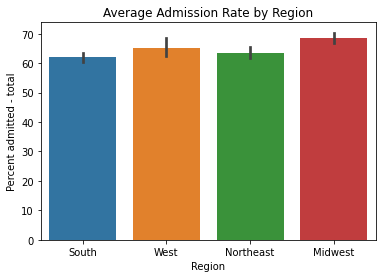

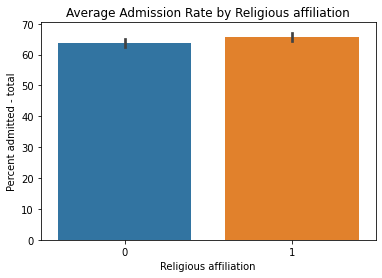

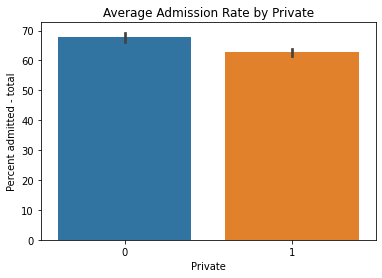

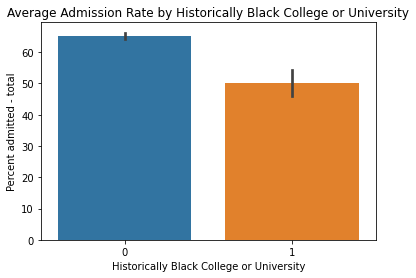

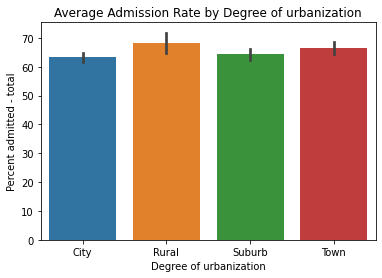

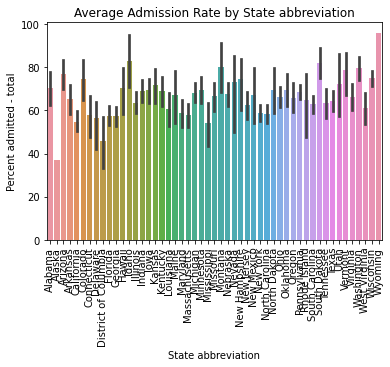

In [26]:
for col in categ_cols:
    if col == "Name":
        continue
    sns.barplot(data=df, x=col, y="Percent admitted - total")
    t = "Average Admission Rate by " + col
    if "State" in col:
        plt.xticks(rotation = 90)
    plt.title(t)
    plt.show()

How is each category distributed in the data? And how does that look across different AR's?

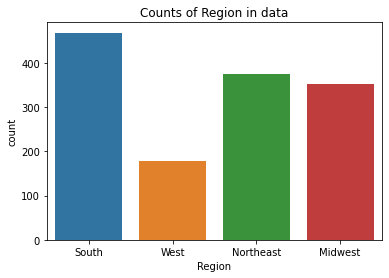

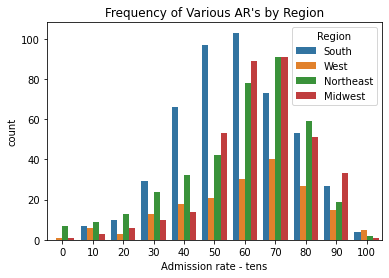

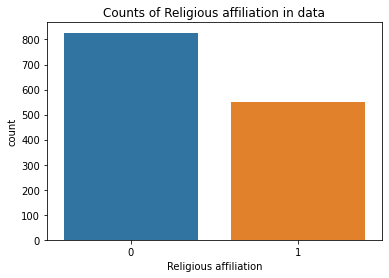

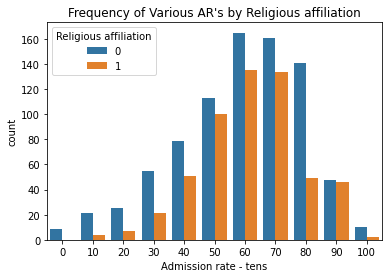

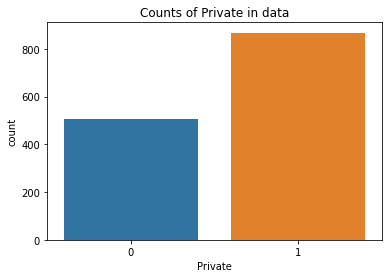

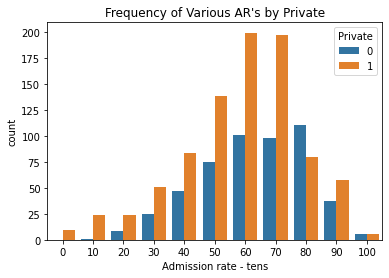

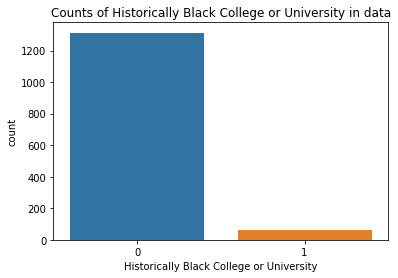

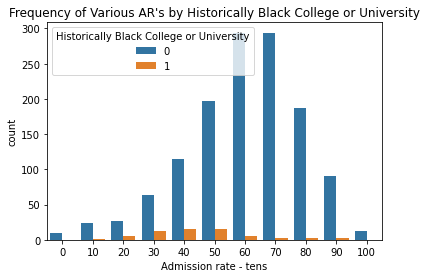

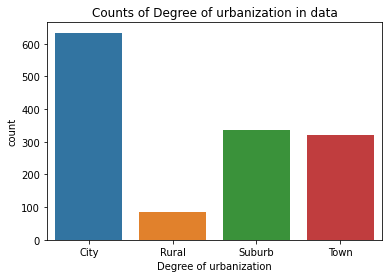

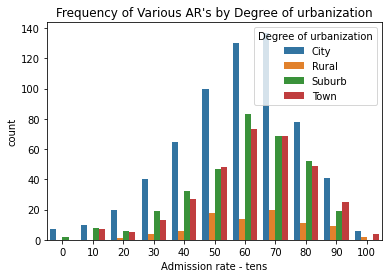

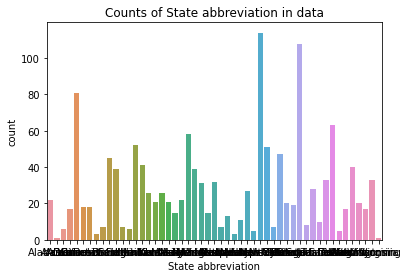

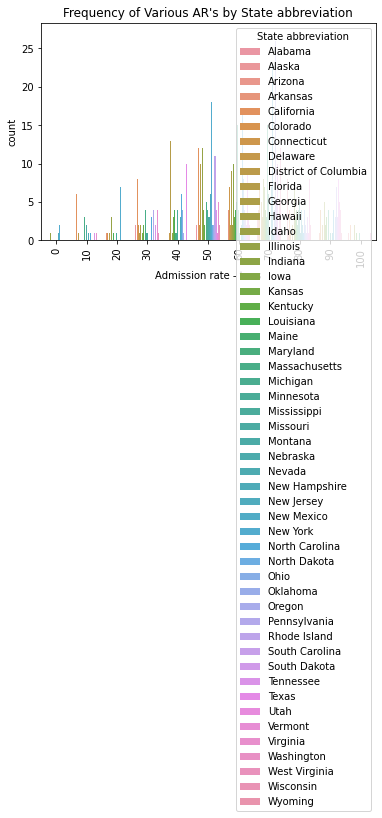

In [27]:
for col in categ_cols:
    if col == "Name":
        continue
    sns.countplot(x=col, data=df)
    t = "Counts of " + col + " in data"
    plt.title(t)
    plt.show()
    sns.countplot(x='Admission rate - tens', data=df, hue=col)
    t = "Frequency of Various AR's by " + col
    if "State" in col:
        plt.xticks(rotation = 90)
    plt.title(t)
    plt.show()



for fun, compare to OSU

(array([0, 1]),
 [Text(0, 0, 'University of Michigan-Ann Arbor'),
  Text(1, 0, 'Ohio State University-Main Campus')])

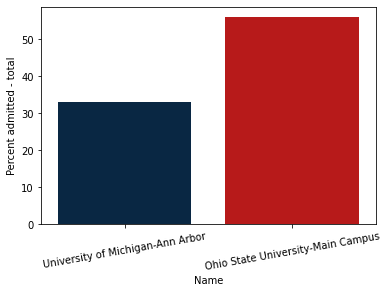

In [28]:
df_osu=df[(df["Name"] == "Ohio State University-Main Campus") | (df["Name"] == "University of Michigan-Ann Arbor")]

sns.barplot(data=df_osu, x="Name", y="Percent admitted - total",palette=["#00274C","#D10000"])
plt.xticks(rotation=10)

Explore trends with tuition

In [29]:
df[['Tuition and fees, 2010-11', 'Tuition and fees, 2011-12',
       'Tuition and fees, 2012-13', 'Tuition and fees, 2013-14']].describe()

Tuition and fees, 2010-11  Tuition and fees, 2011-12  \
count                1372.000000                1372.000000   
mean                19100.625364               20032.930758   
std                 11190.473914               11585.882264   
min                   910.000000                 910.000000   
25%                  7861.750000                8360.750000   
50%                 19617.500000               20495.000000   
75%                 27346.250000               28662.750000   
max                 43990.000000               45290.000000   

       Tuition and fees, 2012-13  Tuition and fees, 2013-14  
count                1373.000000                1376.000000  
mean                20870.368536               21604.350291  
std                 12017.088416               12483.377722  
min                  3770.000000                3850.000000  
25%                  8710.000000                8975.000000  
50%                 21273.000000               22225.000000  
75%                 29840.000000               30897.750000  
max                 47246.000000               49138.000000

Text(0.5, 1.0, 'Average Tuition over Time')

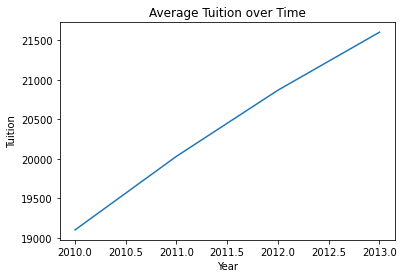

In [30]:
df_tuition_over_time = pd.DataFrame({"Year":[2010,2011,2012,2013],
                                    "Tuition":[19100.625364,20032.930758,20870.368536,21604.350291]})
sns.lineplot(data=df_tuition_over_time, x="Year", y="Tuition")
plt.title("Average Tuition over Time")

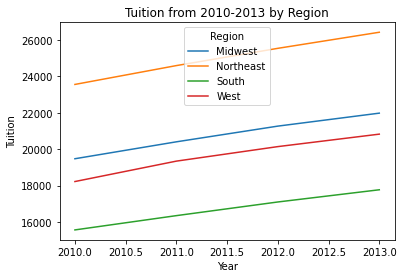

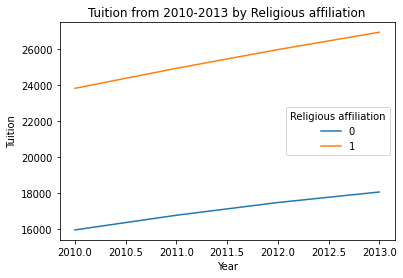

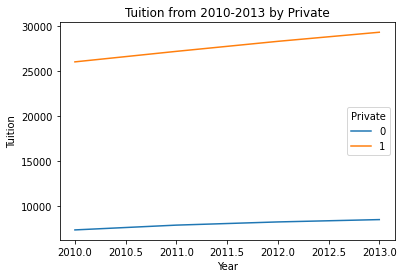

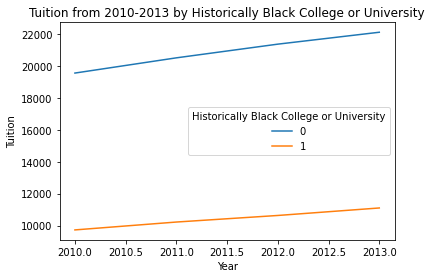

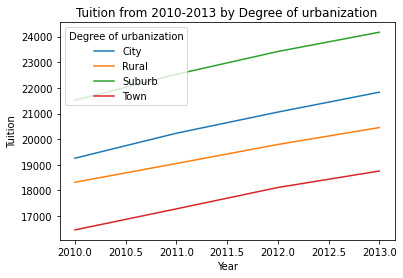

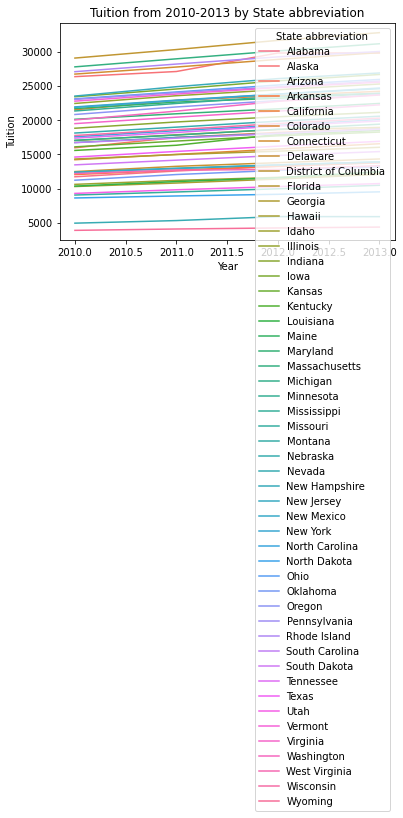

In [31]:
for col in categ_cols:  
    if col == "Name":
        continue
    tuition_cols = ["Tuition and fees, 2010-11","Tuition and fees, 2011-12",
                                                   "Tuition and fees, 2012-13","Tuition and fees, 2013-14"]
    temp_df = df.groupby([col]).mean(numeric_only=True)[tuition_cols]
    breakdowns = temp_df.index
    tuition_over_years = []

    for r in breakdowns:
        for c in tuition_cols:
            tuition_over_years.append(temp_df.loc[r,c])

    new_df = pd.DataFrame({col:list(np.repeat([breakdowns],4)),
                 "Year":[2010,2011,2012,2013] * len(breakdowns),
                 "Tuition":tuition_over_years})
    sns.lineplot(data=new_df, x="Year", y="Tuition",hue=col)
    t="Tuition from 2010-2013 by " + col
    plt.title(t)
    plt.show()

Trends with AR and race

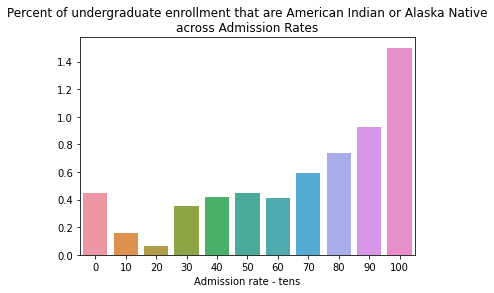

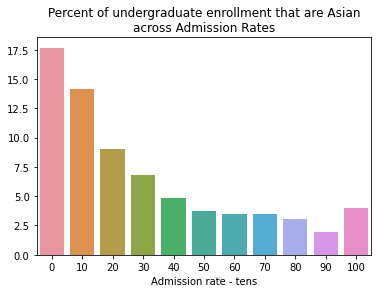

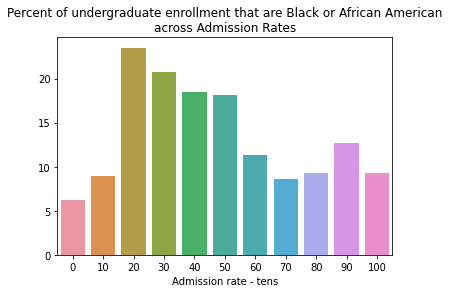

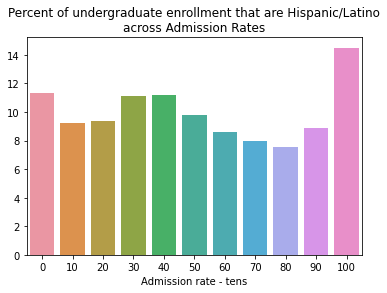

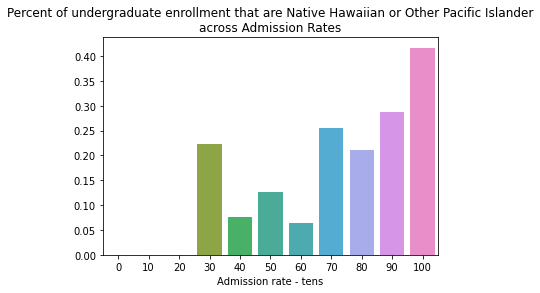

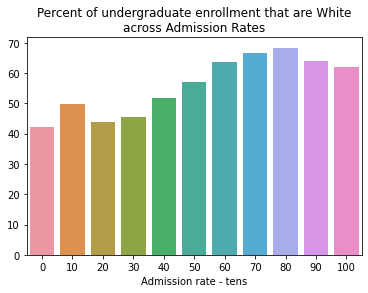

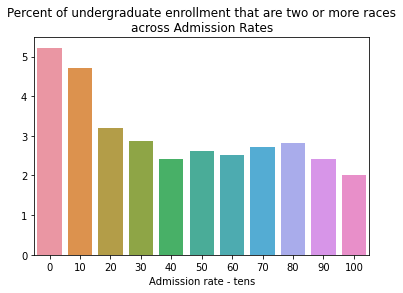

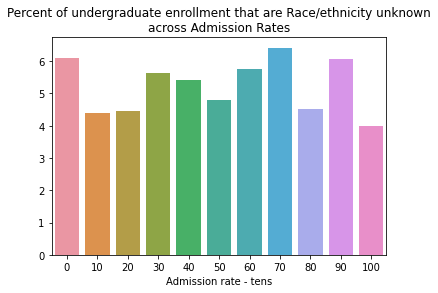

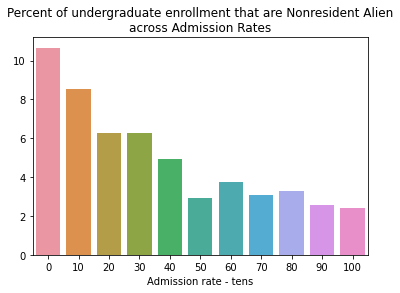

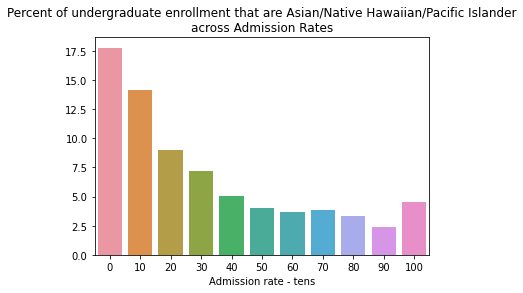

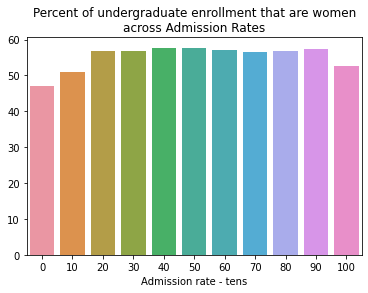

In [32]:
demog_cols = ['Percent of undergraduate enrollment that are American Indian or Alaska Native',
       'Percent of undergraduate enrollment that are Asian',
       'Percent of undergraduate enrollment that are Black or African American',
       'Percent of undergraduate enrollment that are Hispanic/Latino',
       'Percent of undergraduate enrollment that are Native Hawaiian or Other Pacific Islander',
       'Percent of undergraduate enrollment that are White',
       'Percent of undergraduate enrollment that are two or more races',
       'Percent of undergraduate enrollment that are Race/ethnicity unknown',
       'Percent of undergraduate enrollment that are Nonresident Alien',
       'Percent of undergraduate enrollment that are Asian/Native Hawaiian/Pacific Islander',
       'Percent of undergraduate enrollment that are women']
df_demog = df.groupby(["Admission rate - tens"])[demog_cols].mean(numeric_only=True)
df_demog["Admission rate - tens"] = [0,10,20,30,40,50,60,70,80,90,100]

for col in demog_cols:
    sns.barplot(data=df_demog, x="Admission rate - tens",y=col)
    plt.ylabel("")
    t = col + "\nacross Admission Rates"
    plt.title(t)
    plt.show()

In [33]:
df_race = df[["Percent admitted - total","Percent of undergraduate enrollment that are Asian",
   "Percent of undergraduate enrollment that are Hispanic/Latino","Percent of undergraduate enrollment that are White",
   "Percent of undergraduate enrollment that are Black or African American"]]

adm_rate = [100,90,80,70,60,50,40,30,20,10]
race_list = ["Asian","Hispanic/Latino","White","Black"] * len(adm_rate)

df_race_ar = pd.DataFrame({"Race":race_list})
pct_enrl = []
for ar in adm_rate:
    temp_df = df_race[df_race["Percent admitted - total"] < ar].describe()
    for i in range(1,5):
        pct_enrl.append(temp_df.iloc[1,i])
    
df_race_ar["Percent enrollment"] = pct_enrl
df_race_ar["Admission Rate"] = list(np.repeat(adm_rate,4))

df_race_ar
    

Race  Percent enrollment  Admission Rate
0             Asian            4.107771             100
1   Hispanic/Latino            8.958211             100
2             White           60.999267             100
3             Black           13.037390             100
4             Asian            4.266929              90
5   Hispanic/Latino            8.965354              90
6             White           60.770079              90
7             Black           13.063780              90
8             Asian            4.481481              80
9   Hispanic/Latino            9.212963              80
10            White           59.436111              80
11            Black           13.723148              80
12            Asian            4.854777              70
13  Hispanic/Latino            9.685350              70
14            White           56.722293              70
15            Black           15.653503              70
16            Asian            5.678351              60
17  Hispanic/Latino           10.348454              60
18            White           52.373196              60
19            Black           18.307216              60
20            Asian            7.172794              50
21  Hispanic/Latino           10.805147              50
22            White           48.658088              50
23            Black           18.419118              50
24            Asian            9.288732              40
25  Hispanic/Latino           10.422535              40
26            White           45.746479              40
27            Black           18.352113              40
28            Asian           12.136364              30
29  Hispanic/Latino            9.590909              30
30            White           45.863636              30
31            Black           15.621212              30
32            Asian           15.088235              20
33  Hispanic/Latino            9.794118              20
34            White           47.705882              20
35            Black            8.205882              20
36            Asian           17.666667              10
37  Hispanic/Latino           11.333333              10
38            White           42.111111              10
39            Black            6.222222              10

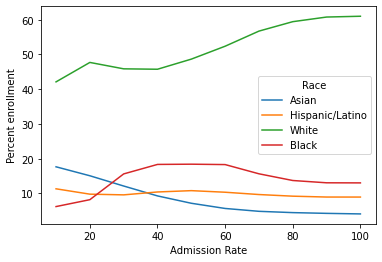

In [34]:
sns.lineplot(data=df_race_ar, y="Percent enrollment", x="Admission Rate",hue="Race")
   # plt.title("Admis ")
plt.show()

# Diagnostics (for regression model)

https://medium.com/@abhilash.sirigari/a-complete-model-diagnostics-of-multivariate-linear-regression-90aace20ecaf

<AxesSubplot: >

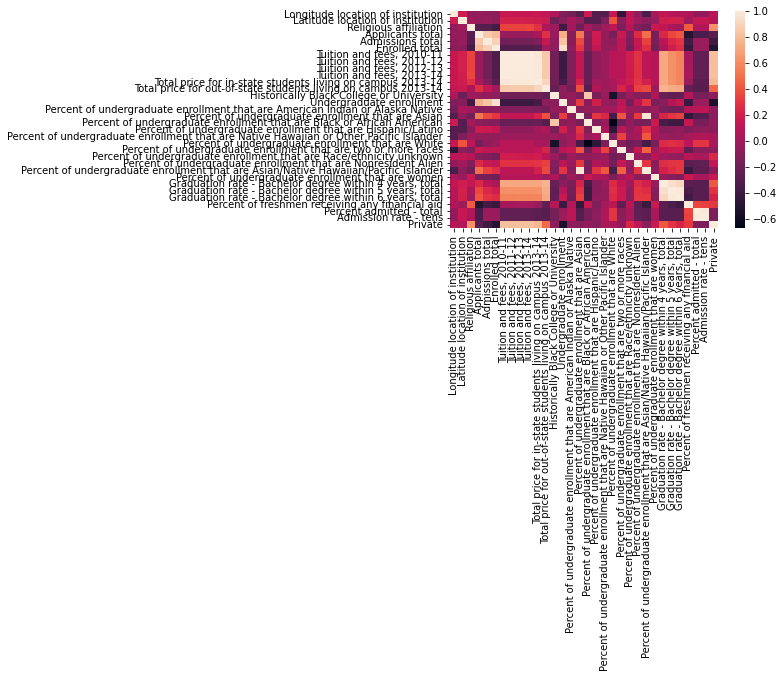

In [35]:
# investigate multicollinearity
corr = df.corr(numeric_only=True)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)


In [36]:
# based on multicollinearity or deemed irrelevant, remove these columns before running lin reg
cols_to_remove_regression = ["Admissions total","Enrolled total","Tuition and fees, 2010-11","Tuition and fees, 2011-12",
                            "Tuition and fees, 2012-13","Graduation rate - Bachelor degree within 5 years, total",
                             "Graduation rate - Bachelor degree within 6 years, total",
                             "Total price for out-of-state students living on campus 2013-14",
                             "Total price for in-state students living on campus 2013-14",
                            "Percent of undergraduate enrollment that are two or more races",
                            "Percent of undergraduate enrollment that are Race/ethnicity unknown",
                            "Percent of undergraduate enrollment that are Asian/Native Hawaiian/Pacific Islander",
                            "Admission rate - tens","Name","State abbreviation",
                            'Percent of freshmen submitting SAT scores']

In [37]:
# remove cols
# check back to remove SAT/ACT, longitude/latitude, white/asian pct, applicants?, hbcu vs white pct
regression_cols = []
for col in df.columns:
    if col not in cols_to_remove_regression:
        regression_cols.append(col)
        
df = df[regression_cols]
df.columns

Index(['Longitude location of institution', 'Latitude location of institution',
       'Region', 'Religious affiliation', 'Applicants total',
       'Tuition and fees, 2013-14', 'Historically Black College or University',
       'Undergraduate enrollment',
       'Percent of undergraduate enrollment that are American Indian or Alaska Native',
       'Percent of undergraduate enrollment that are Asian',
       'Percent of undergraduate enrollment that are Black or African American',
       'Percent of undergraduate enrollment that are Hispanic/Latino',
       'Percent of undergraduate enrollment that are Native Hawaiian or Other Pacific Islander',
       'Percent of undergraduate enrollment that are White',
       'Percent of undergraduate enrollment that are Nonresident Alien',
       'Percent of undergraduate enrollment that are women',
       'Graduation rate - Bachelor degree within 4 years, total',
       'Percent of freshmen receiving any financial aid',
       'Percent admitted -

<AxesSubplot: >

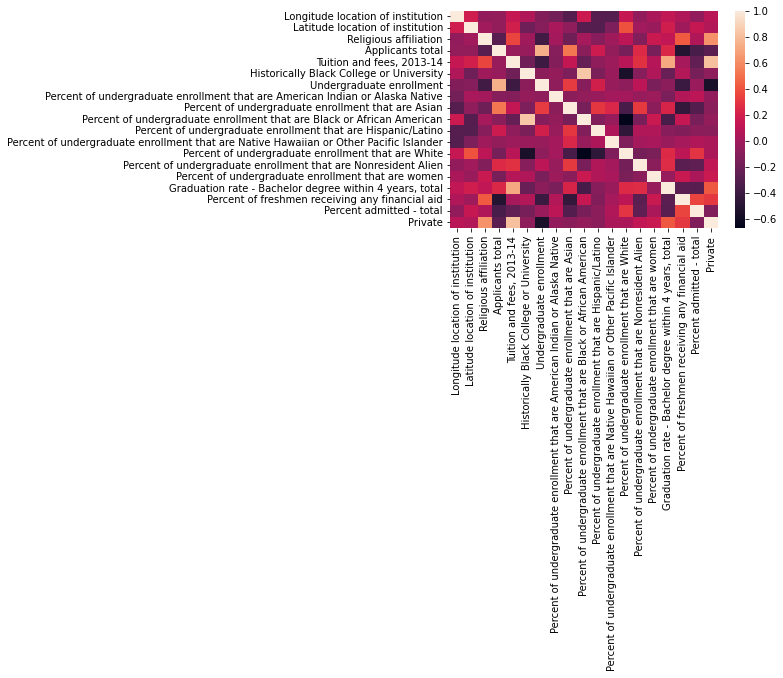

In [38]:
# check new multicollinearity after removed cols
corr = df.corr(numeric_only=True)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [39]:
# add dummy variables
names_regions = df["Region"].value_counts().index
for n in names_regions:
    colname = "Region_" + n
    df[colname] = df["Region"] == n
    df[colname] = df[colname].map(int)
    
names_urban = df["Degree of urbanization"].value_counts().index
for n in names_urban:
    colname = "Deg_urban_" + n
    df[colname] = df["Degree of urbanization"] == n
    df[colname] = df[colname].map(int)

/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/225872125.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colname] = df["Region"] == n
/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/225872125.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colname] = df[colname].map(int)
/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/225872125.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [40]:
# remove original region / degree of urb columns bc we added new dummy cols
df = df.loc[:, ~df.columns.isin(['Region', 'Degree of urbanization'])]

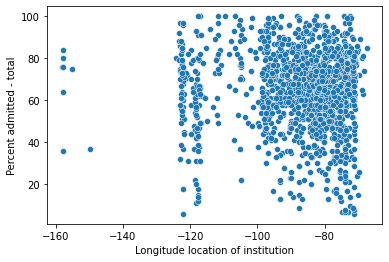

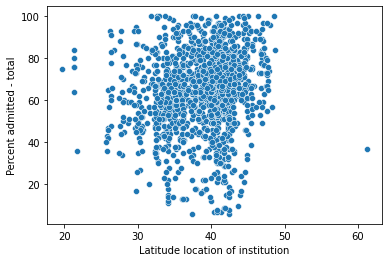

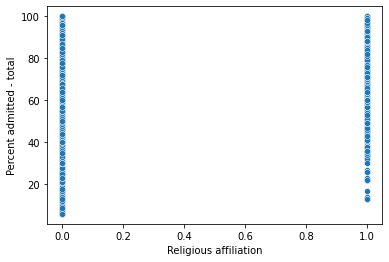

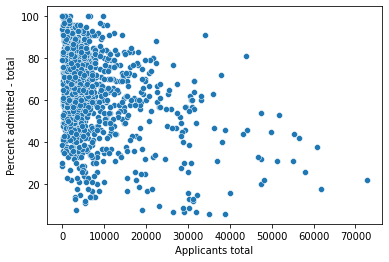

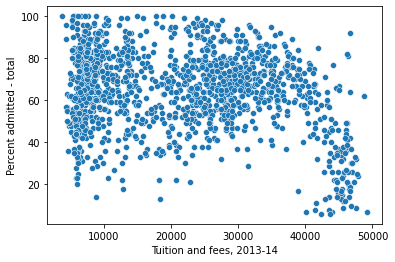

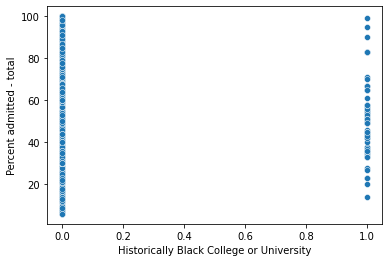

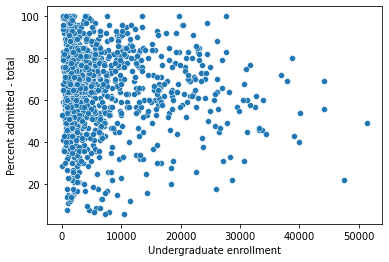

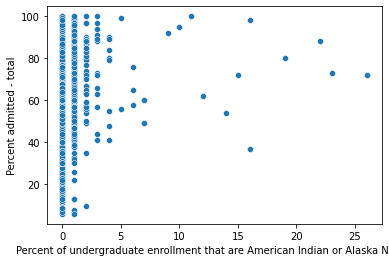

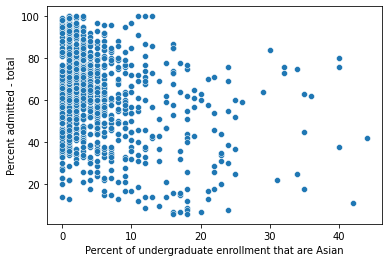

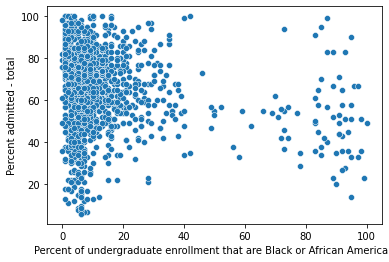

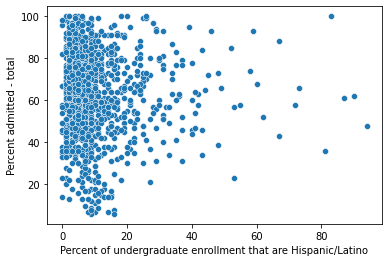

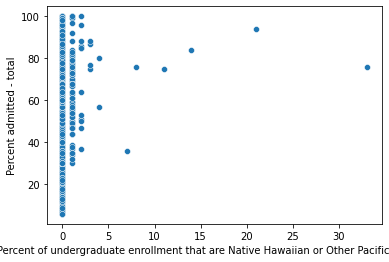

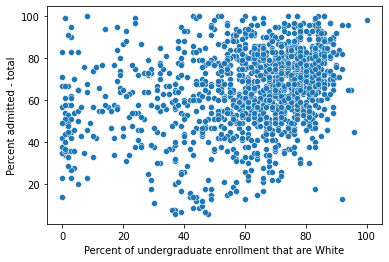

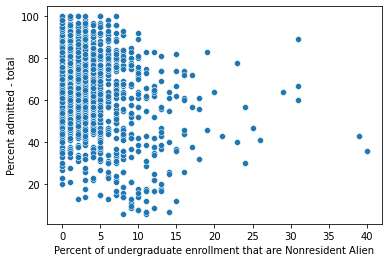

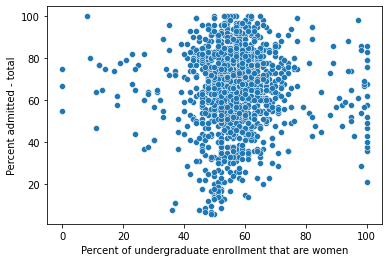

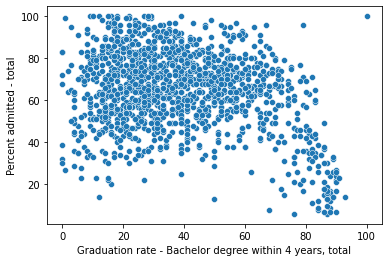

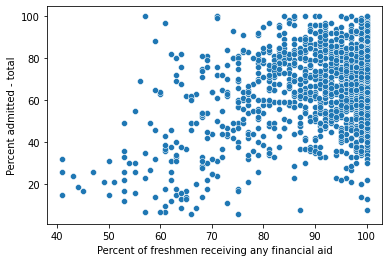

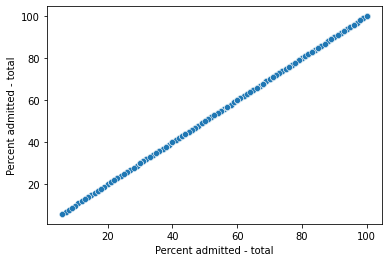

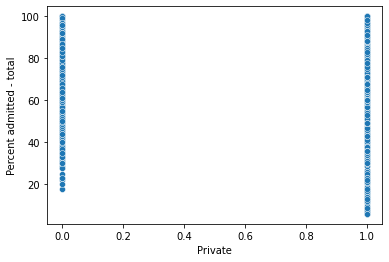

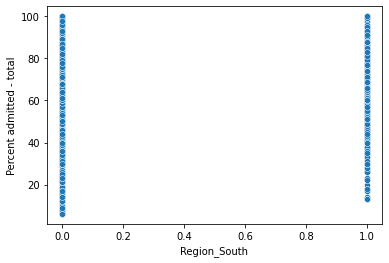

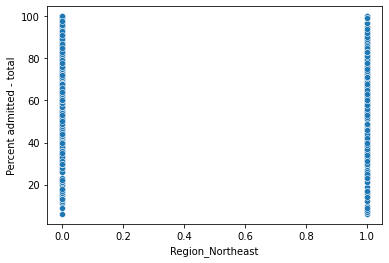

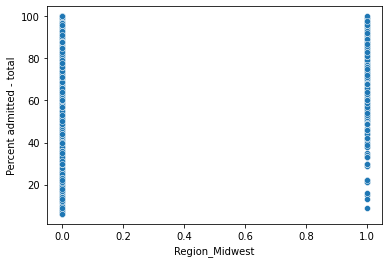

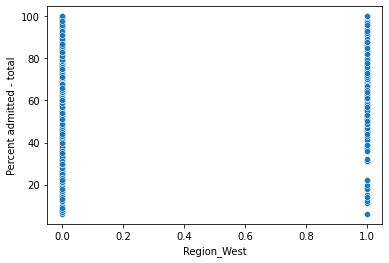

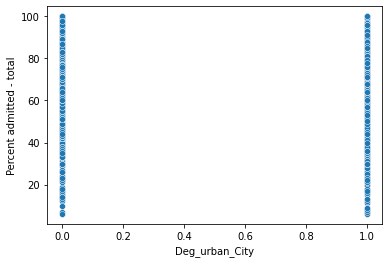

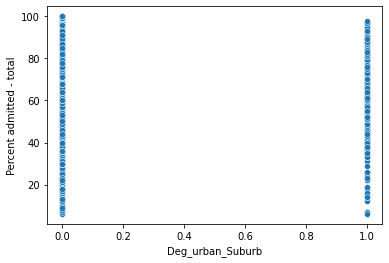

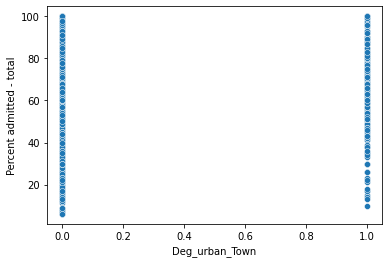

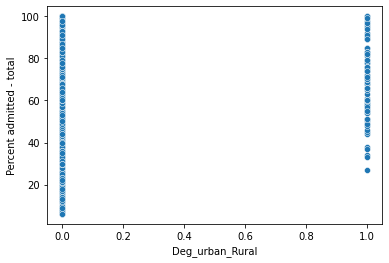

In [41]:
# investigate scatterplots to find linear relationship with admission rate
for col in df.columns:
    sns.scatterplot(data=df, x=col, y="Percent admitted - total")
    plt.show()
    
# longitude isnt very linear

/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


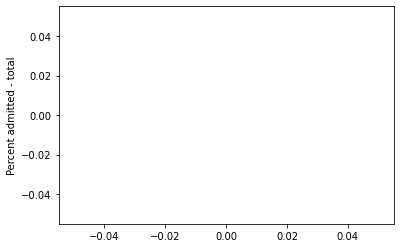

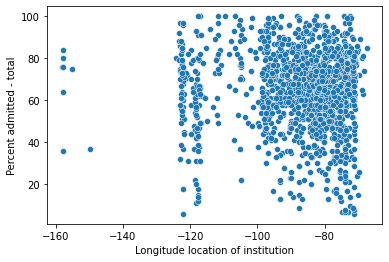

                                   Longitude location of institution  \
Longitude location of institution                           1.000000   
Percent admitted - total                                   -0.060912   
log                                                              NaN   

                                   Percent admitted - total  log  
Longitude location of institution                 -0.060912  NaN  
Percent admitted - total                           1.000000  NaN  
log                                                     NaN  NaN  
----------------------------------------------------


/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


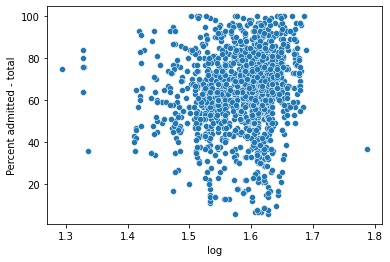

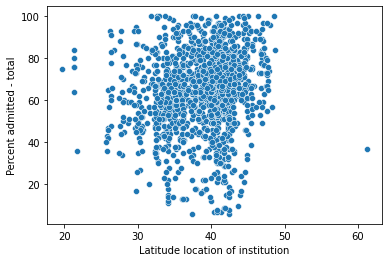

                                  Latitude location of institution  \
Latitude location of institution                          1.000000   
Percent admitted - total                                  0.140716   
log                                                       0.994661   

                                  Percent admitted - total       log  
Latitude location of institution                  0.140716  0.994661  
Percent admitted - total                          1.000000  0.133161  
log                                               0.133161  1.000000  
----------------------------------------------------


/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


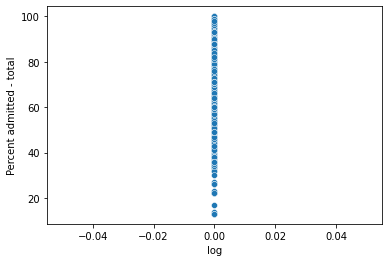

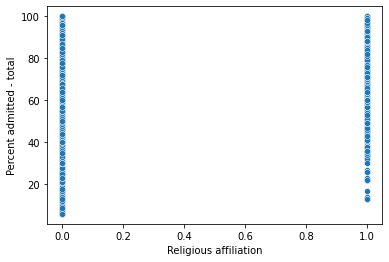

                          Religious affiliation  Percent admitted - total  log
Religious affiliation                  1.000000                  0.055164  NaN
Percent admitted - total               0.055164                  1.000000  NaN
log                                         NaN                       NaN  NaN
----------------------------------------------------


/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


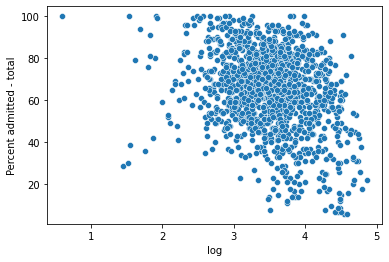

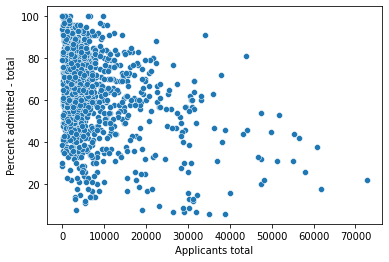

                          Applicants total  Percent admitted - total       log
Applicants total                  1.000000                 -0.348620  0.765698
Percent admitted - total         -0.348620                  1.000000 -0.308649
log                               0.765698                 -0.308649  1.000000
----------------------------------------------------


/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


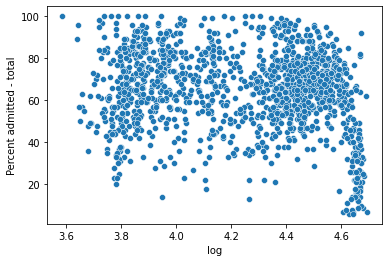

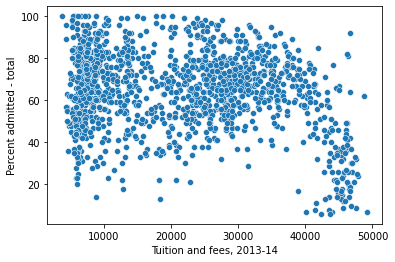

                           Tuition and fees, 2013-14  \
Tuition and fees, 2013-14                   1.000000   
Percent admitted - total                   -0.247203   
log                                         0.966046   

                           Percent admitted - total       log  
Tuition and fees, 2013-14                 -0.247203  0.966046  
Percent admitted - total                   1.000000 -0.174953  
log                                       -0.174953  1.000000  
----------------------------------------------------


/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


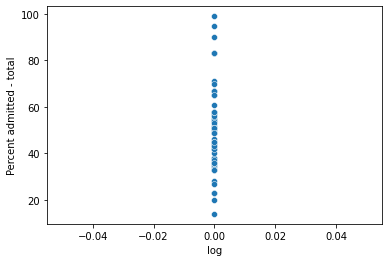

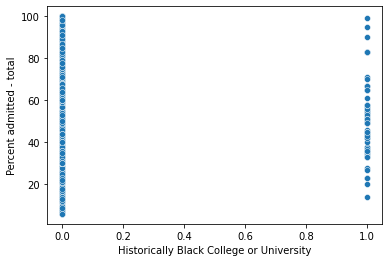

                                          Historically Black College or University  \
Historically Black College or University                                  1.000000   
Percent admitted - total                                                 -0.167663   
log                                                                            NaN   

                                          Percent admitted - total  log  
Historically Black College or University                 -0.167663  NaN  
Percent admitted - total                                  1.000000  NaN  
log                                                            NaN  NaN  
----------------------------------------------------


/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


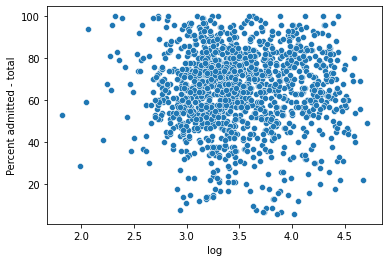

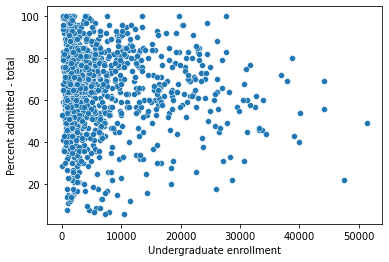

                          Undergraduate enrollment  Percent admitted - total  \
Undergraduate enrollment                  1.000000                 -0.027950   
Percent admitted - total                 -0.027950                  1.000000   
log                                       0.849547                 -0.011406   

                               log  
Undergraduate enrollment  0.849547  
Percent admitted - total -0.011406  
log                       1.000000  
----------------------------------------------------


/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


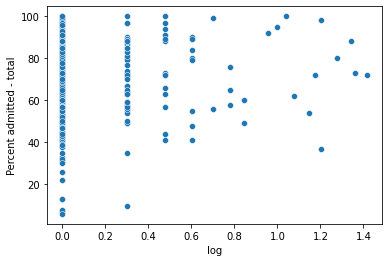

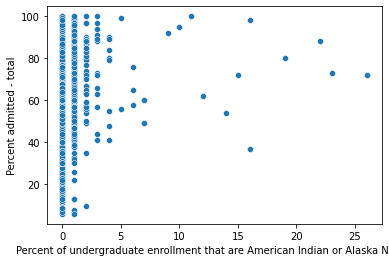

                                                    Percent of undergraduate enrollment that are American Indian or Alaska Native  \
Percent of undergraduate enrollment that are Am...                                           1.000000                               
Percent admitted - total                                                                     0.101109                               
log                                                                                          0.886045                               

                                                    Percent admitted - total  \
Percent of undergraduate enrollment that are Am...                  0.101109   
Percent admitted - total                                            1.000000   
log                                                                 0.085188   

                                                         log  
Percent of undergraduate enrollment that are Am...  0.886045  
Percent admitted - t

/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


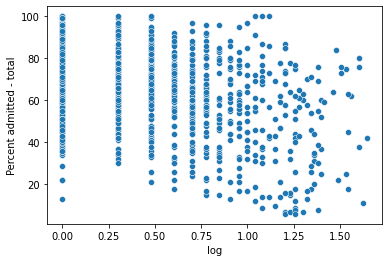

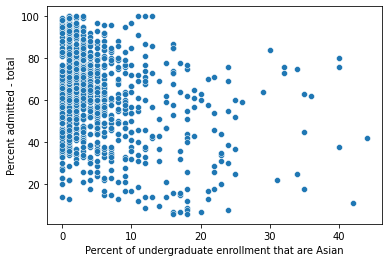

                                                    Percent of undergraduate enrollment that are Asian  \
Percent of undergraduate enrollment that are Asian                                           1.000000    
Percent admitted - total                                                                    -0.306807    
log                                                                                          0.865223    

                                                    Percent admitted - total  \
Percent of undergraduate enrollment that are Asian                 -0.306807   
Percent admitted - total                                            1.000000   
log                                                                -0.355597   

                                                         log  
Percent of undergraduate enrollment that are Asian  0.865223  
Percent admitted - total                           -0.355597  
log                                                 1.000000  
--

/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


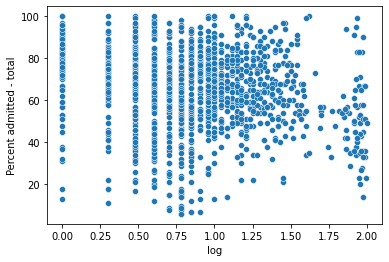

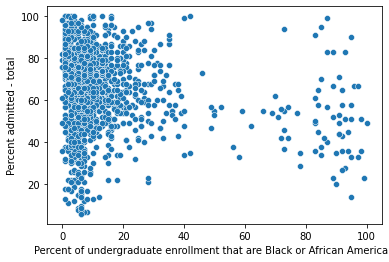

                                                    Percent of undergraduate enrollment that are Black or African American  \
Percent of undergraduate enrollment that are Bl...                                           1.000000                        
Percent admitted - total                                                                    -0.159516                        
log                                                                                          0.815842                        

                                                    Percent admitted - total  \
Percent of undergraduate enrollment that are Bl...                 -0.159516   
Percent admitted - total                                            1.000000   
log                                                                -0.150307   

                                                         log  
Percent of undergraduate enrollment that are Bl...  0.815842  
Percent admitted - total                        

/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


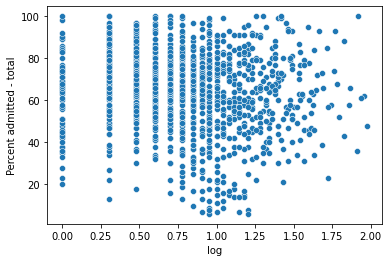

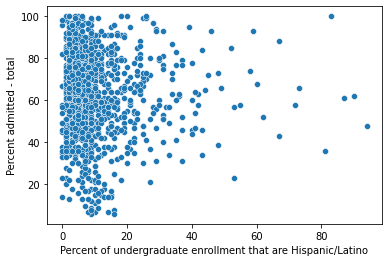

                                                    Percent of undergraduate enrollment that are Hispanic/Latino  \
Percent of undergraduate enrollment that are Hi...                                           1.000000              
Percent admitted - total                                                                    -0.078636              
log                                                                                          0.829239              

                                                    Percent admitted - total  \
Percent of undergraduate enrollment that are Hi...                 -0.078636   
Percent admitted - total                                            1.000000   
log                                                                -0.138014   

                                                         log  
Percent of undergraduate enrollment that are Hi...  0.829239  
Percent admitted - total                           -0.138014  
log                      

/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


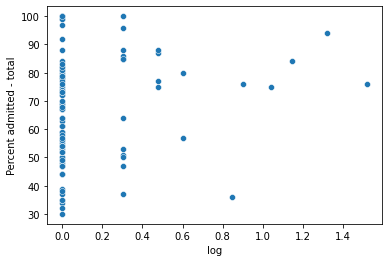

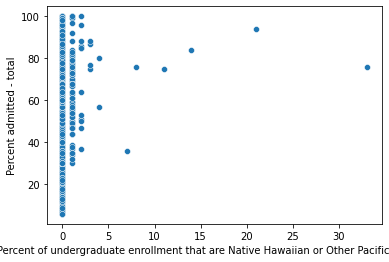

                                                    Percent of undergraduate enrollment that are Native Hawaiian or Other Pacific Islander  \
Percent of undergraduate enrollment that are Na...                                           1.000000                                        
Percent admitted - total                                                                     0.052389                                        
log                                                                                          0.875619                                        

                                                    Percent admitted - total  \
Percent of undergraduate enrollment that are Na...                  0.052389   
Percent admitted - total                                            1.000000   
log                                                                 0.190898   

                                                         log  
Percent of undergraduate enrollment that are Na

/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


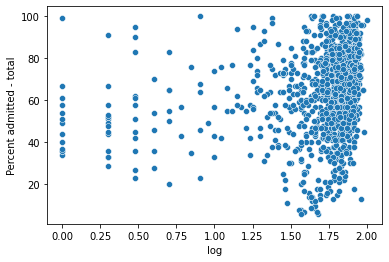

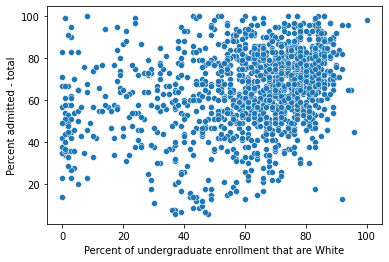

                                                    Percent of undergraduate enrollment that are White  \
Percent of undergraduate enrollment that are White                                           1.000000    
Percent admitted - total                                                                     0.295258    
log                                                                                          0.882812    

                                                    Percent admitted - total  \
Percent of undergraduate enrollment that are White                  0.295258   
Percent admitted - total                                            1.000000   
log                                                                 0.225861   

                                                         log  
Percent of undergraduate enrollment that are White  0.882812  
Percent admitted - total                            0.225861  
log                                                 1.000000  
--

/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


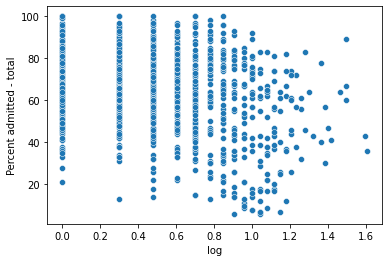

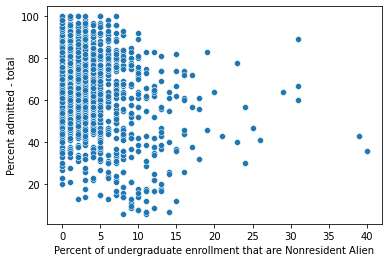

                                                    Percent of undergraduate enrollment that are Nonresident Alien  \
Percent of undergraduate enrollment that are No...                                           1.000000                
Percent admitted - total                                                                    -0.256556                
log                                                                                          0.870009                

                                                    Percent admitted - total  \
Percent of undergraduate enrollment that are No...                 -0.256556   
Percent admitted - total                                            1.000000   
log                                                                -0.277770   

                                                         log  
Percent of undergraduate enrollment that are No...  0.870009  
Percent admitted - total                           -0.277770  
log              

/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


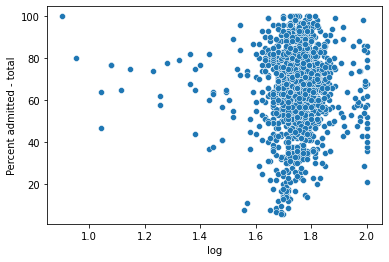

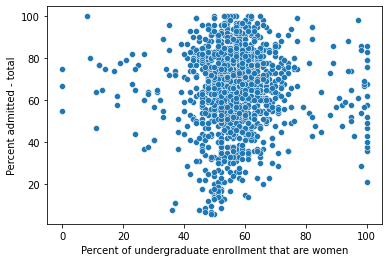

                                                    Percent of undergraduate enrollment that are women  \
Percent of undergraduate enrollment that are women                                           1.000000    
Percent admitted - total                                                                     0.030134    
log                                                                                          0.942661    

                                                    Percent admitted - total  \
Percent of undergraduate enrollment that are women                  0.030134   
Percent admitted - total                                            1.000000   
log                                                                 0.020988   

                                                         log  
Percent of undergraduate enrollment that are women  0.942661  
Percent admitted - total                            0.020988  
log                                                 1.000000  
--

/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


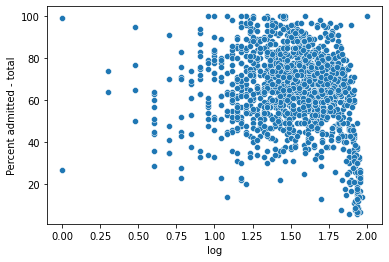

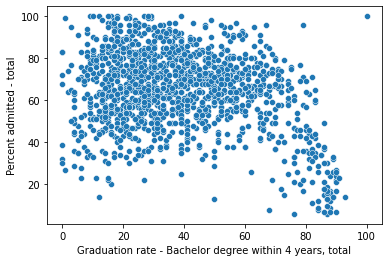

                                                    Graduation rate - Bachelor degree within 4 years, total  \
Graduation rate - Bachelor degree within 4 year...                                           1.000000         
Percent admitted - total                                                                    -0.291469         
log                                                                                          0.922294         

                                                    Percent admitted - total  \
Graduation rate - Bachelor degree within 4 year...                 -0.291469   
Percent admitted - total                                            1.000000   
log                                                                -0.167215   

                                                         log  
Graduation rate - Bachelor degree within 4 year...  0.922294  
Percent admitted - total                           -0.167215  
log                                          

/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


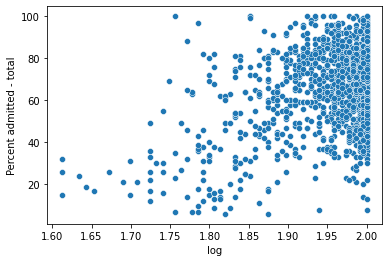

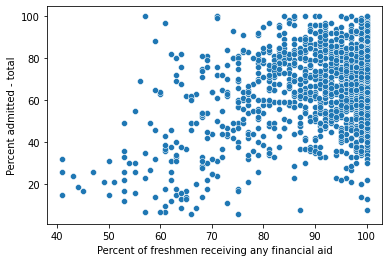

                                                 Percent of freshmen receiving any financial aid  \
Percent of freshmen receiving any financial aid                                         1.000000   
Percent admitted - total                                                                0.348078   
log                                                                                     0.994311   

                                                 Percent admitted - total  \
Percent of freshmen receiving any financial aid                  0.348078   
Percent admitted - total                                         1.000000   
log                                                              0.367654   

                                                      log  
Percent of freshmen receiving any financial aid  0.994311  
Percent admitted - total                         0.367654  
log                                              1.000000  
--------------------------------------------------

/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


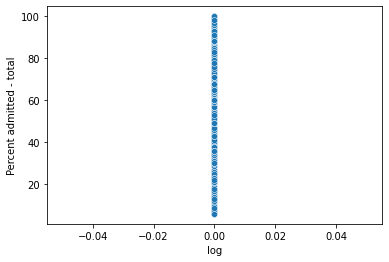

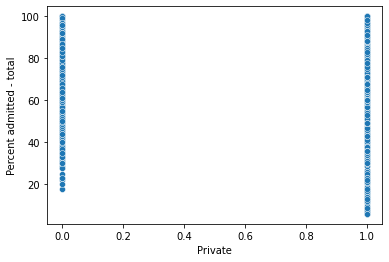

                          Private  Percent admitted - total  log
Private                   1.00000                  -0.13153  NaN
Percent admitted - total -0.13153                   1.00000  NaN
log                           NaN                       NaN  NaN
----------------------------------------------------


/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


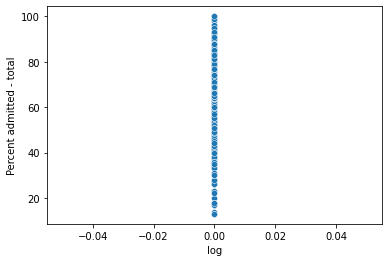

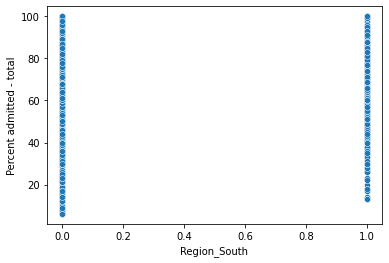

                          Region_South  Percent admitted - total  log
Region_South                  1.000000                 -0.096833  NaN
Percent admitted - total     -0.096833                  1.000000  NaN
log                                NaN                       NaN  NaN
----------------------------------------------------


/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


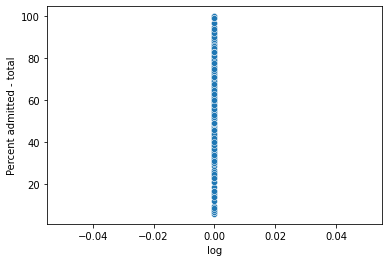

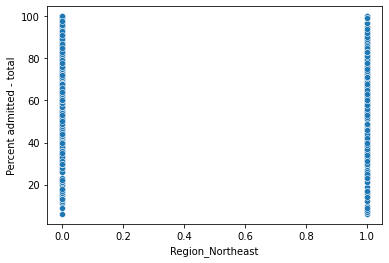

                          Region_Northeast  Percent admitted - total  log
Region_Northeast                  1.000000                 -0.033416  NaN
Percent admitted - total         -0.033416                  1.000000  NaN
log                                    NaN                       NaN  NaN
----------------------------------------------------


/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


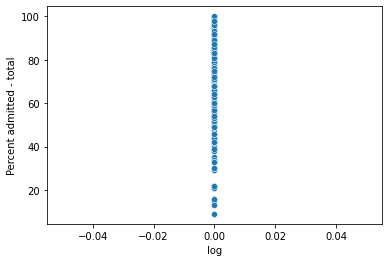

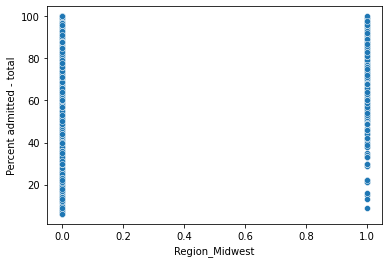

                          Region_Midwest  Percent admitted - total  log
Region_Midwest                  1.000000                  0.127834  NaN
Percent admitted - total        0.127834                  1.000000  NaN
log                                  NaN                       NaN  NaN
----------------------------------------------------


/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


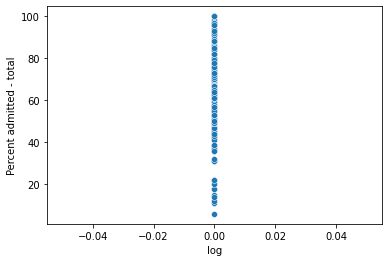

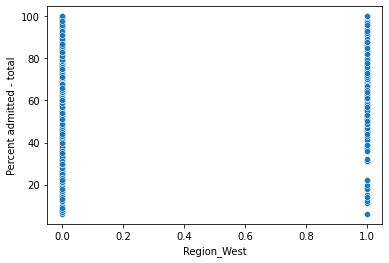

                          Region_West  Percent admitted - total  log
Region_West                  1.000000                  0.014902  NaN
Percent admitted - total     0.014902                  1.000000  NaN
log                               NaN                       NaN  NaN
----------------------------------------------------


/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


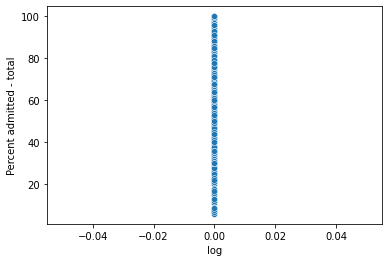

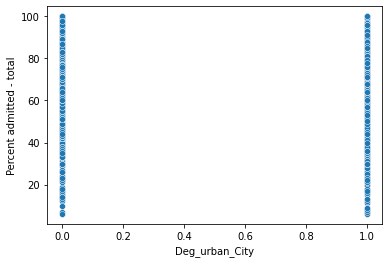

                          Deg_urban_City  Percent admitted - total  log
Deg_urban_City                  1.000000                 -0.066668  NaN
Percent admitted - total       -0.066668                  1.000000  NaN
log                                  NaN                       NaN  NaN
----------------------------------------------------


/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


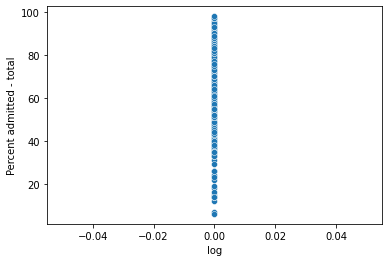

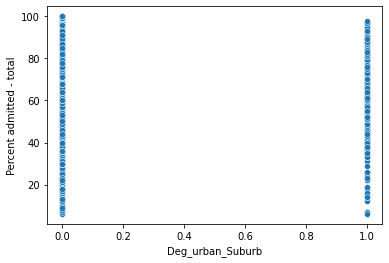

                          Deg_urban_Suburb  Percent admitted - total  log
Deg_urban_Suburb                  1.000000                 -0.007049  NaN
Percent admitted - total         -0.007049                  1.000000  NaN
log                                    NaN                       NaN  NaN
----------------------------------------------------


/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


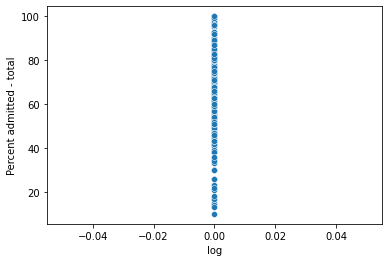

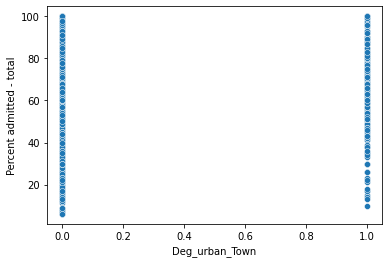

                          Deg_urban_Town  Percent admitted - total  log
Deg_urban_Town                  1.000000                  0.057271  NaN
Percent admitted - total        0.057271                  1.000000  NaN
log                                  NaN                       NaN  NaN
----------------------------------------------------


/var/folders/g4/86zp2jms1qxc7lry7pqtg1c80000gn/T/ipykernel_81988/4278837565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["log"] = df_temp[col].apply(np.log10)


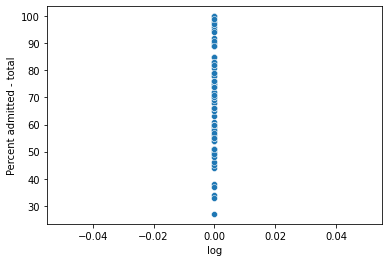

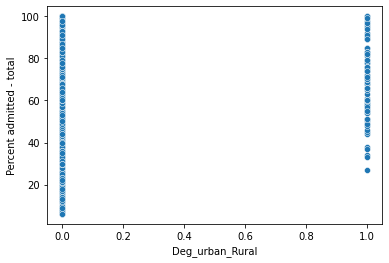

                          Deg_urban_Rural  Percent admitted - total  log
Deg_urban_Rural                  1.000000                  0.050127  NaN
Percent admitted - total         0.050127                  1.000000  NaN
log                                   NaN                       NaN  NaN
----------------------------------------------------


In [42]:
# compare to log transforms - seems like % columns prefer log transforms
for col in df.columns:
    if col == "Percent admitted - total":
        continue
    df_temp = df[[col,"Percent admitted - total"]]
    df_temp["log"] = df_temp[col].apply(np.log10)
    sns.scatterplot(data=df_temp, x="log", y="Percent admitted - total")
    plt.show()
    sns.scatterplot(data=df_temp, x=col, y="Percent admitted - total")
    plt.show()
    print(df_temp.corr())
    print("----------------------------------------------------")

# Regression (never used model)

In [43]:
x = df[['Longitude location of institution', 'Latitude location of institution',
       'Religious affiliation', 'Applicants total',
       'Tuition and fees, 2013-14', 'Historically Black College or University',
       'Undergraduate enrollment',
       'Percent of undergraduate enrollment that are American Indian or Alaska Native',
       'Percent of undergraduate enrollment that are Asian',
       'Percent of undergraduate enrollment that are Black or African American',
       'Percent of undergraduate enrollment that are Hispanic/Latino',
       'Percent of undergraduate enrollment that are Native Hawaiian or Other Pacific Islander',
       'Percent of undergraduate enrollment that are White',
       'Percent of undergraduate enrollment that are Nonresident Alien',
       'Percent of undergraduate enrollment that are women',
       'Graduation rate - Bachelor degree within 4 years, total',
       'Percent of freshmen receiving any financial aid',
       'Private', 'Region_South',
       'Region_Northeast', 'Region_Midwest', 'Region_West', 'Deg_urban_City',
       'Deg_urban_Suburb', 'Deg_urban_Town', 'Deg_urban_Rural']]
y = df['Percent admitted - total']
 

In [44]:
import statsmodels.api as sm

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     Percent admitted - total   R-squared:                       0.394
Model:                                  OLS   Adj. R-squared:                  0.383
Method:                       Least Squares   F-statistic:                     36.62
Date:                      Mon, 20 Feb 2023   Prob (F-statistic):          1.28e-128
Time:                              21:30:50   Log-Likelihood:                -5637.6
No. Observations:                      1376   AIC:                         1.133e+04
Df Residuals:                          1351   BIC:                         1.146e+04
Df Model:                                24                                         
Covariance Type:                  nonrobust                                         
                                                                                             coef    std err          t      P>|t|      [0.025      0.

eval_env: 1


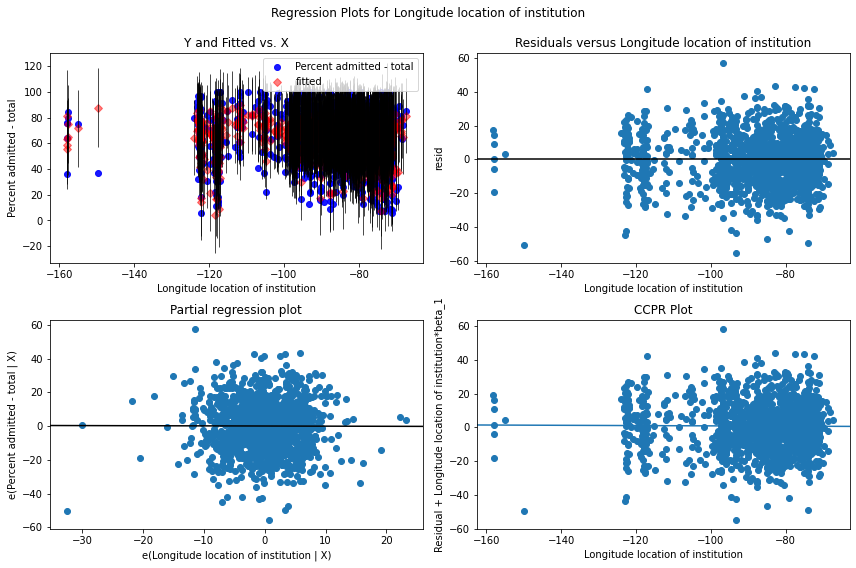

eval_env: 1


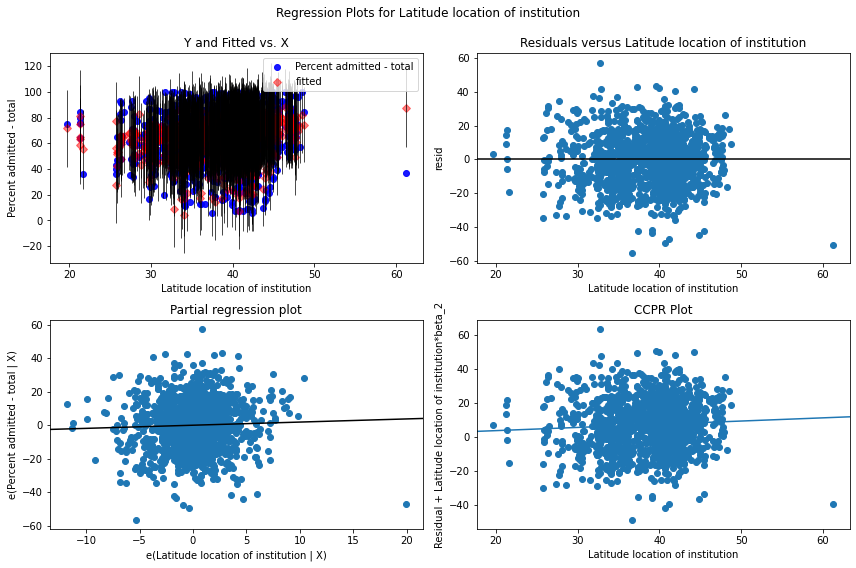

eval_env: 1


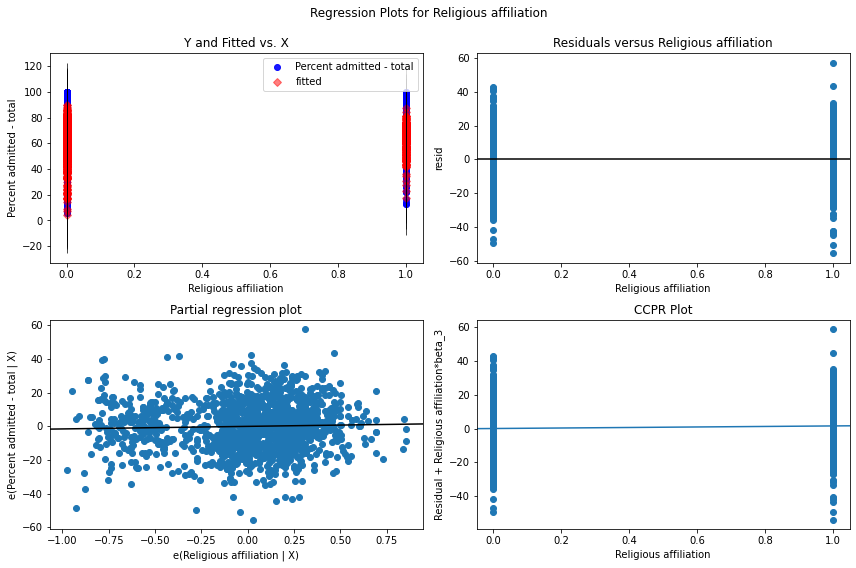

eval_env: 1


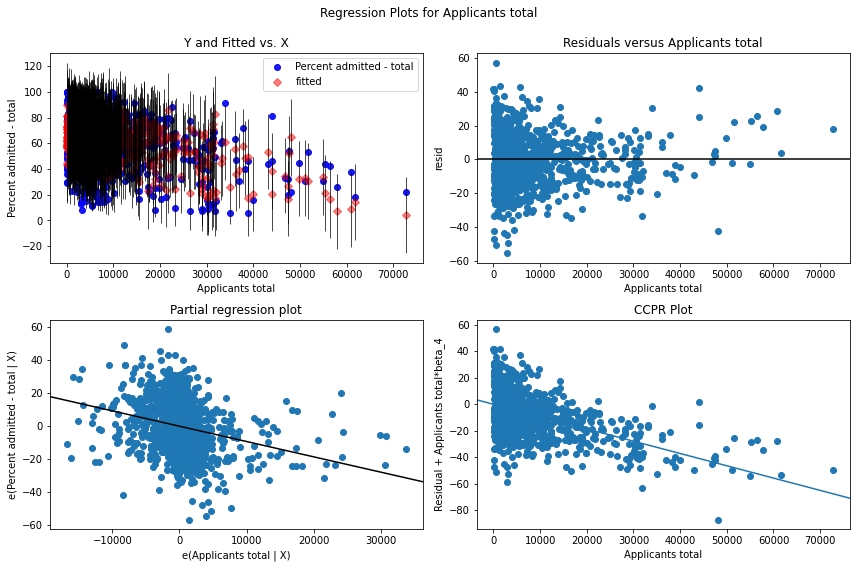

eval_env: 1


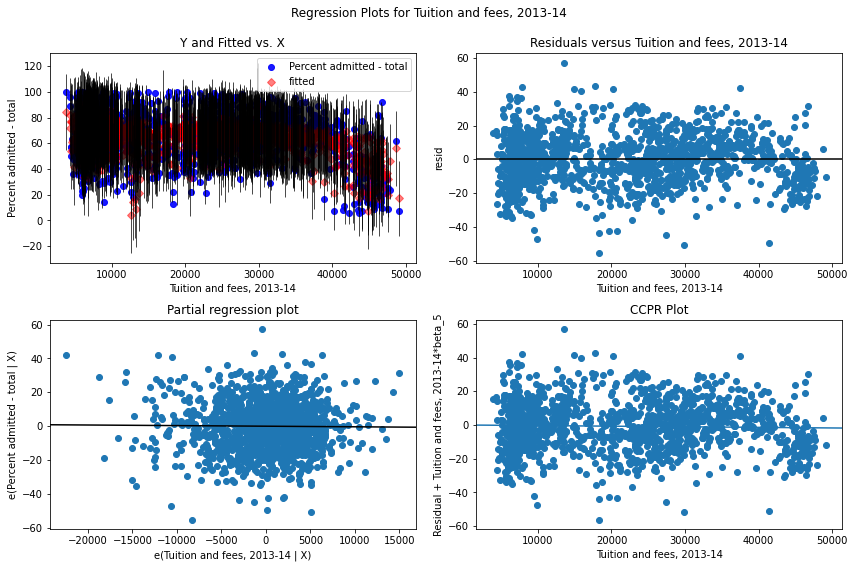

eval_env: 1


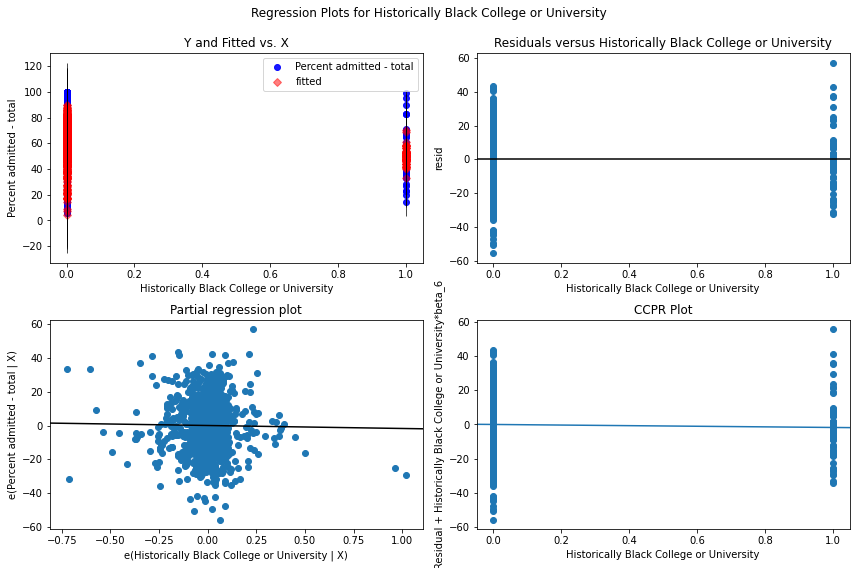

eval_env: 1


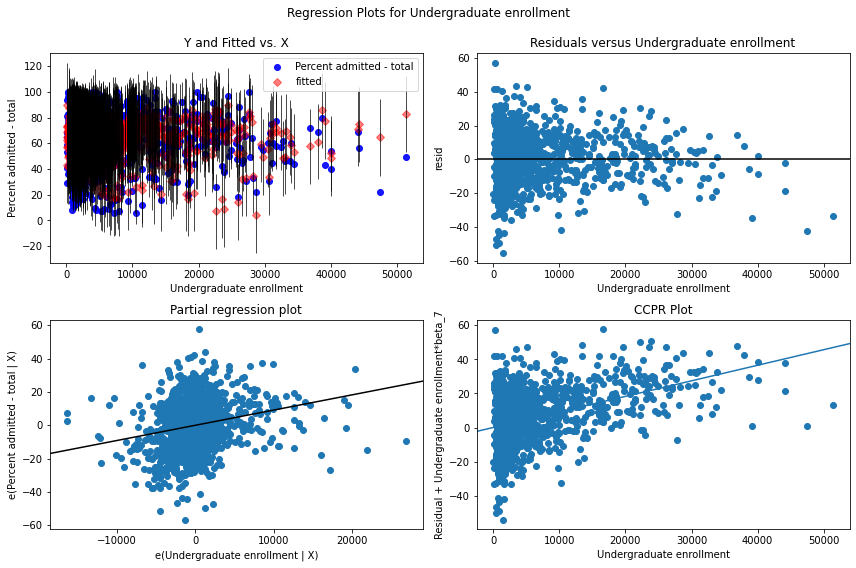

eval_env: 1


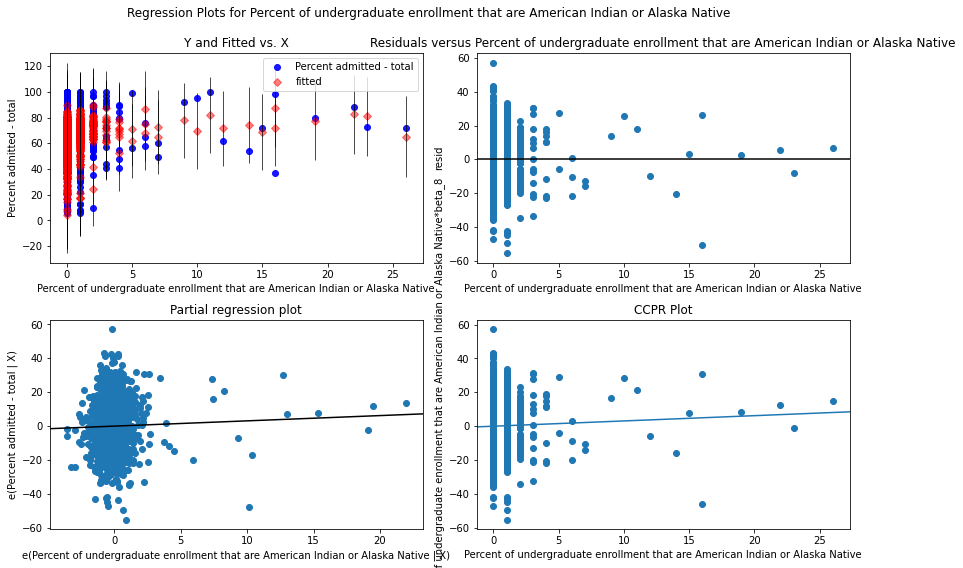

eval_env: 1


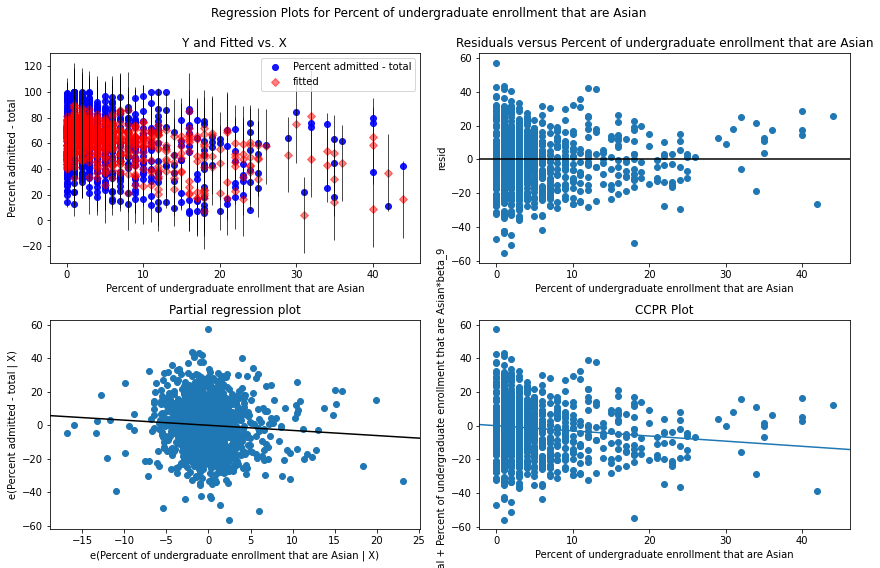

eval_env: 1


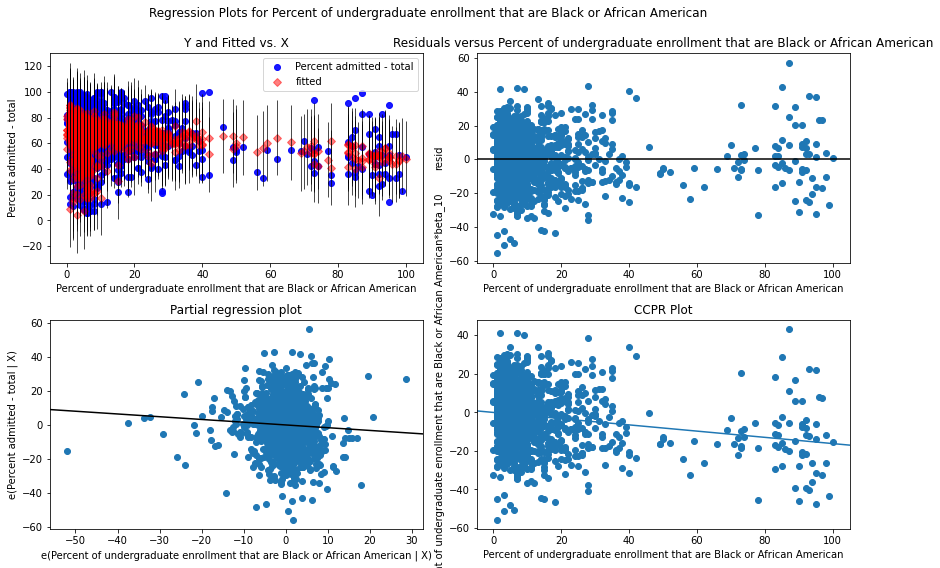

eval_env: 1


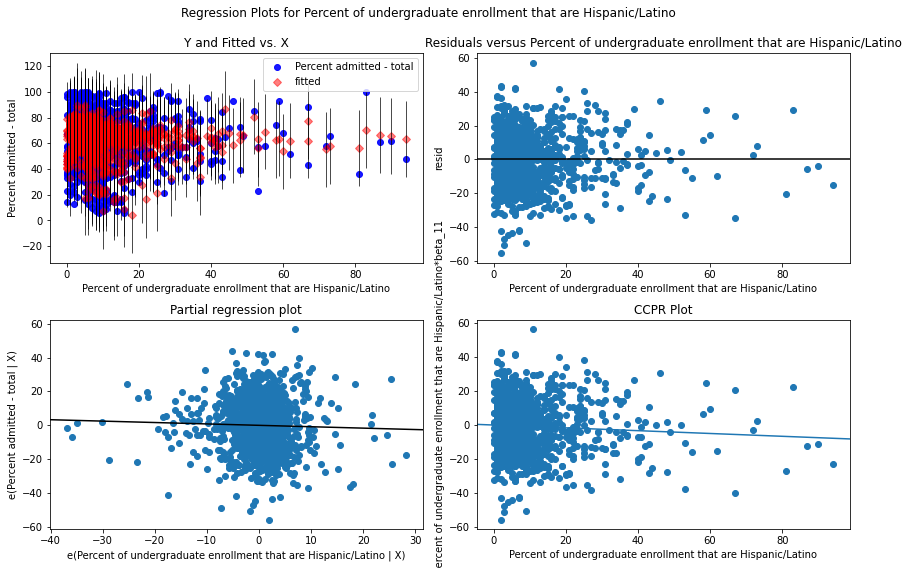

eval_env: 1


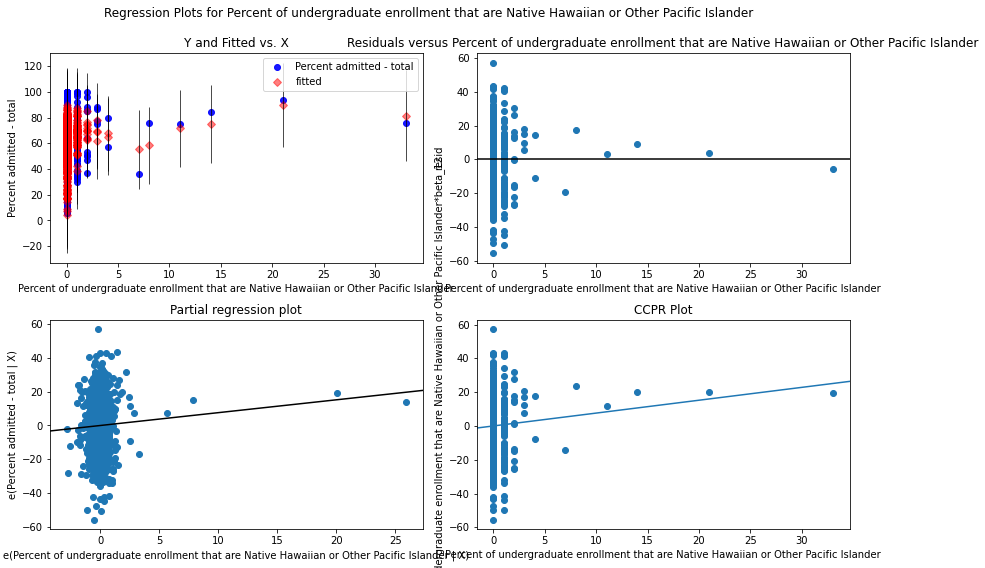

eval_env: 1


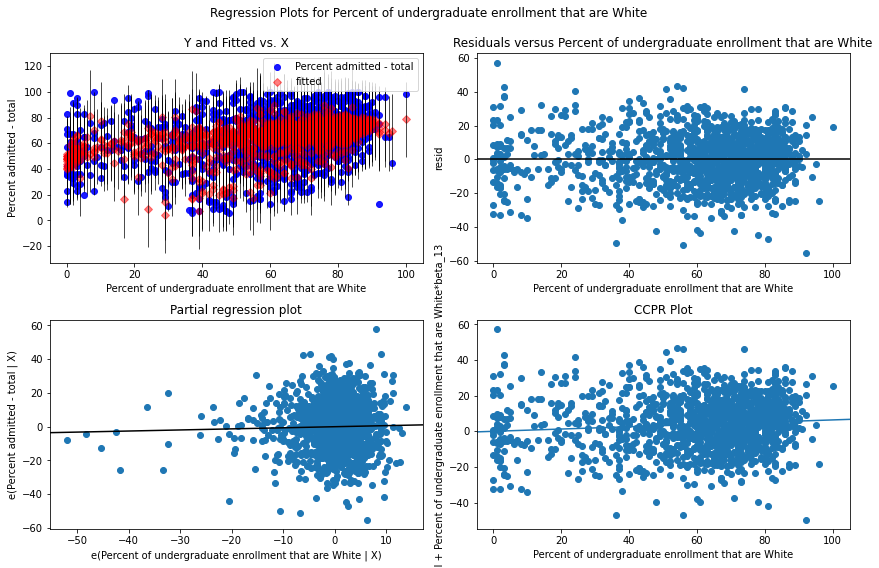

eval_env: 1


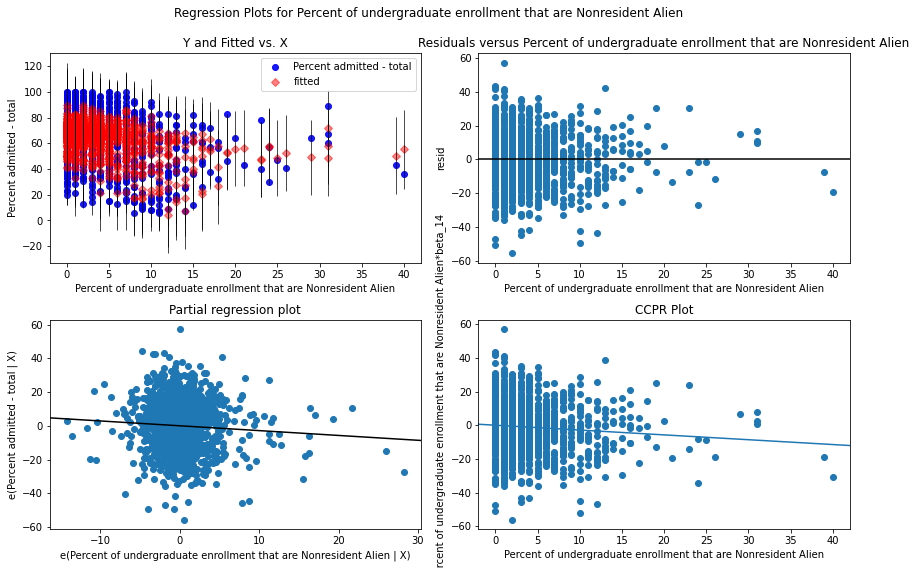

eval_env: 1


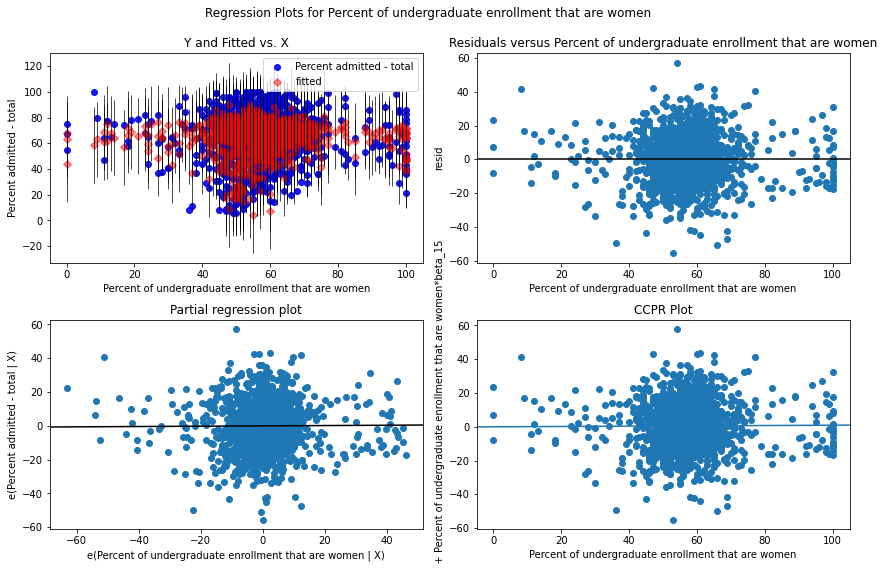

eval_env: 1


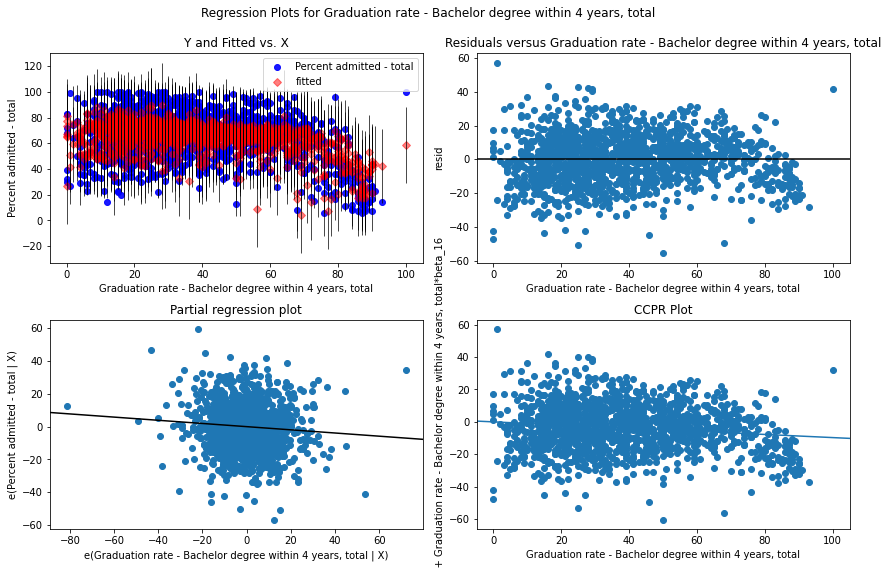

eval_env: 1


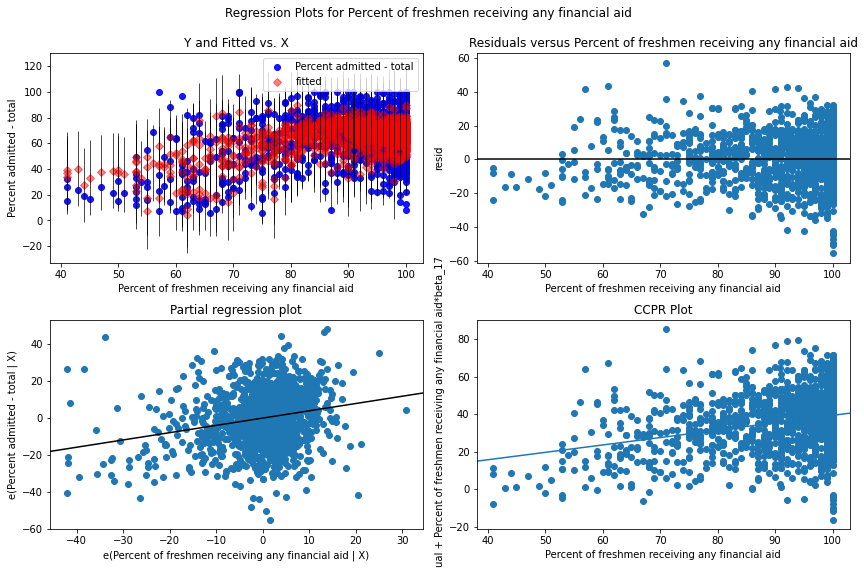

eval_env: 1


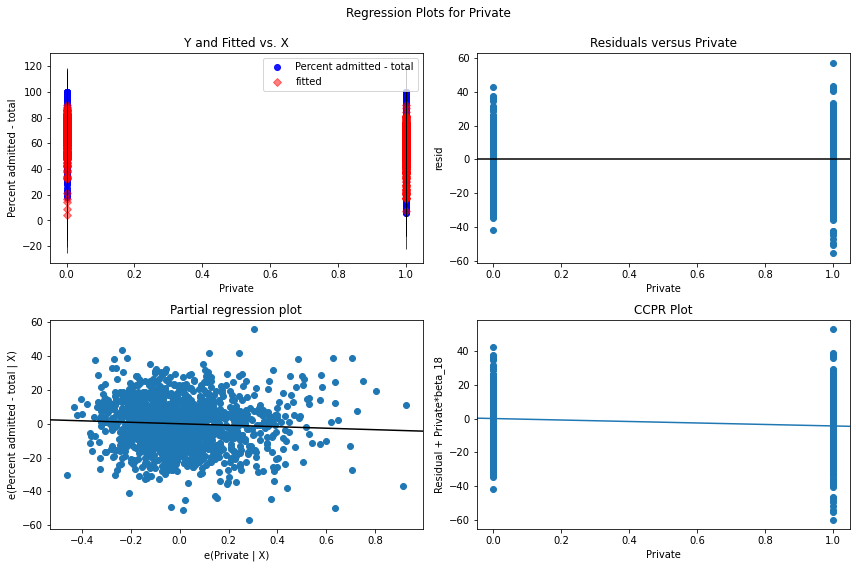

eval_env: 1


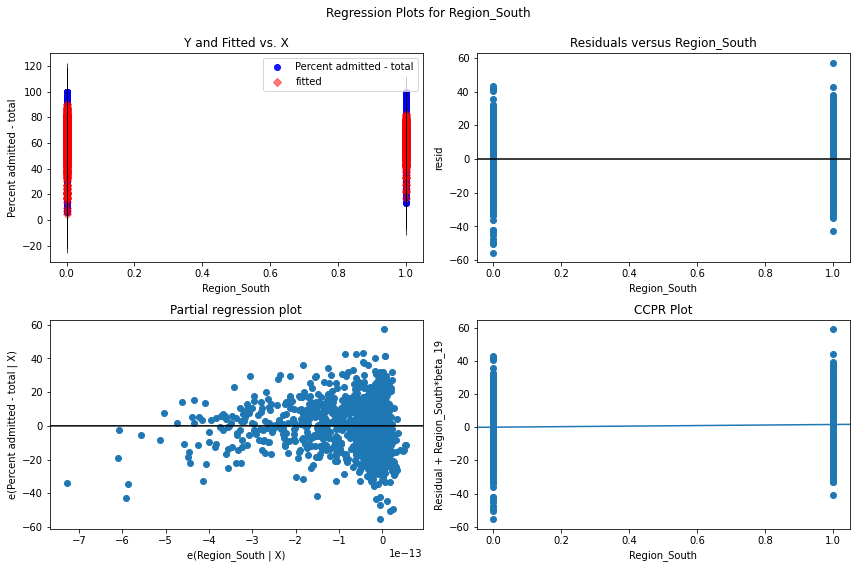

eval_env: 1


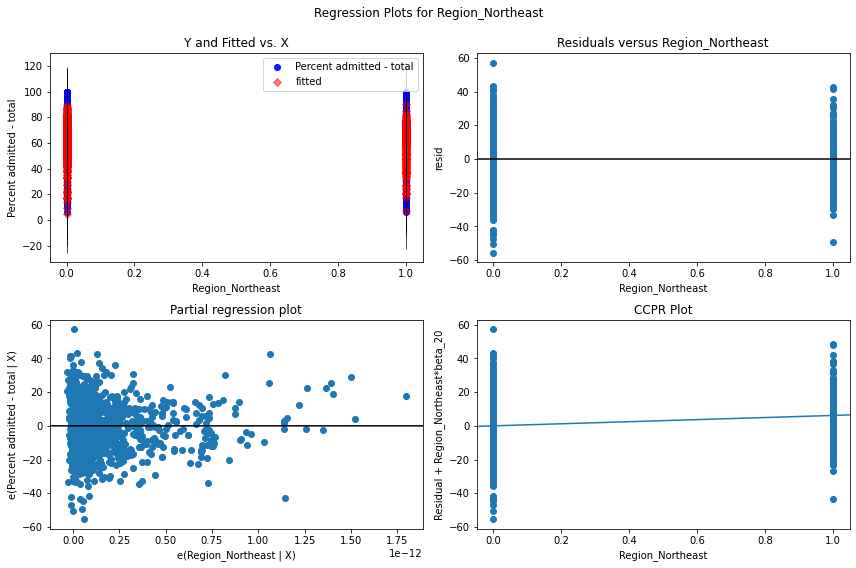

eval_env: 1


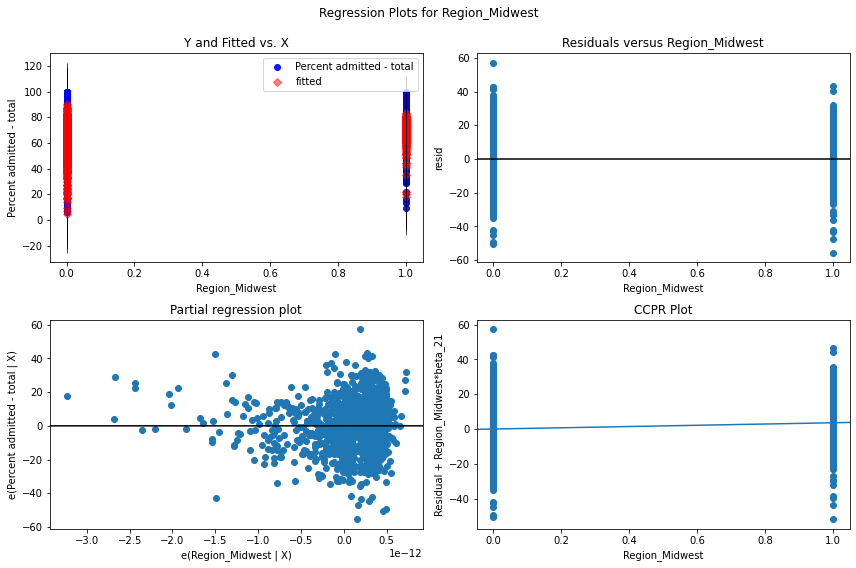

eval_env: 1


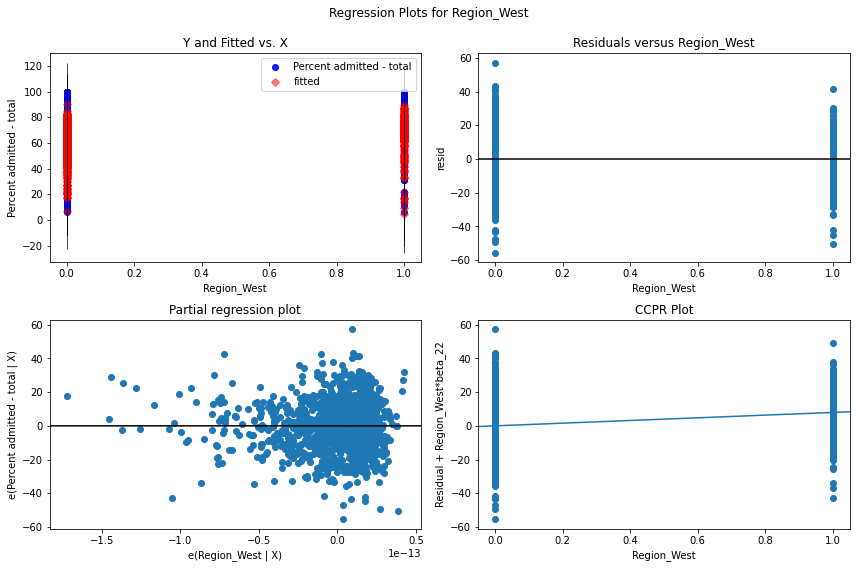

eval_env: 1


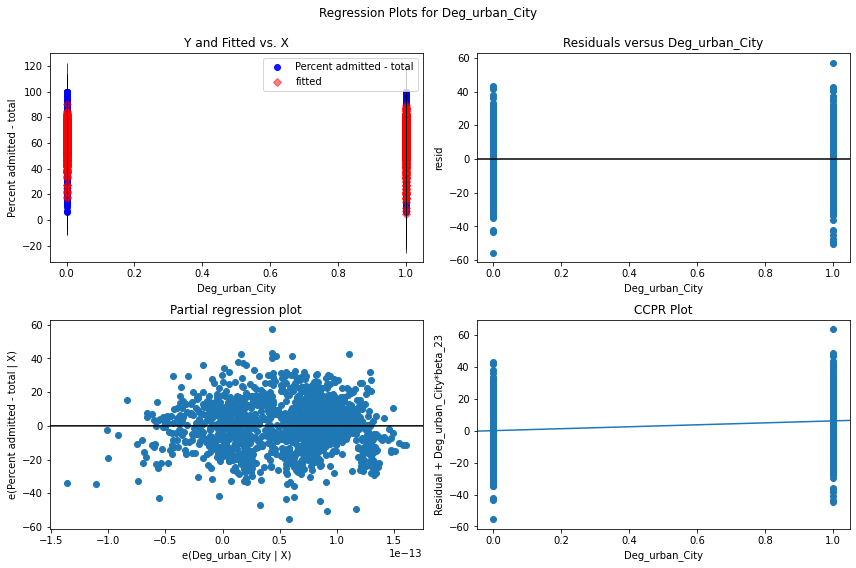

eval_env: 1


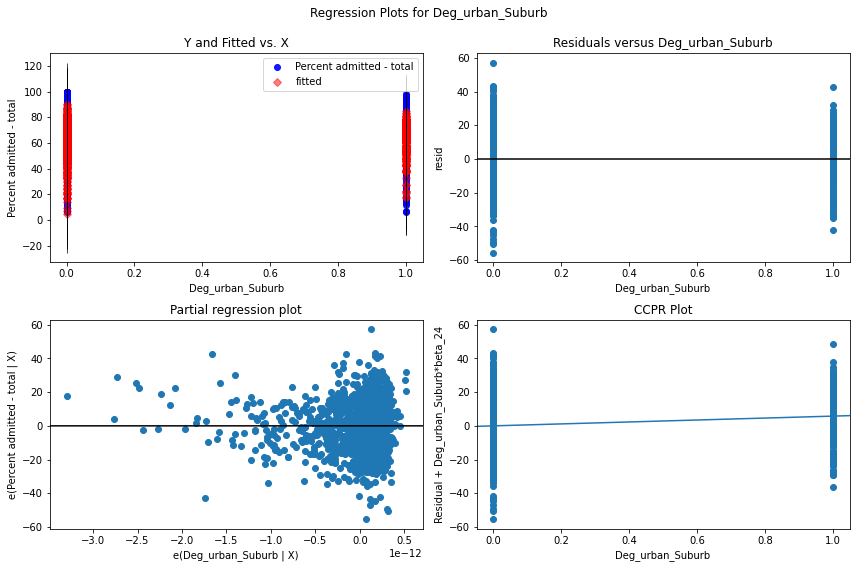

eval_env: 1


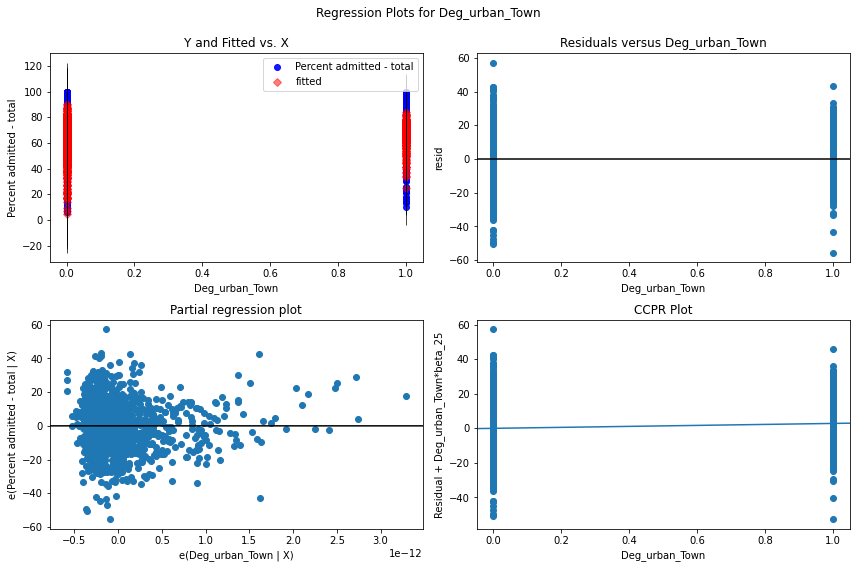

eval_env: 1


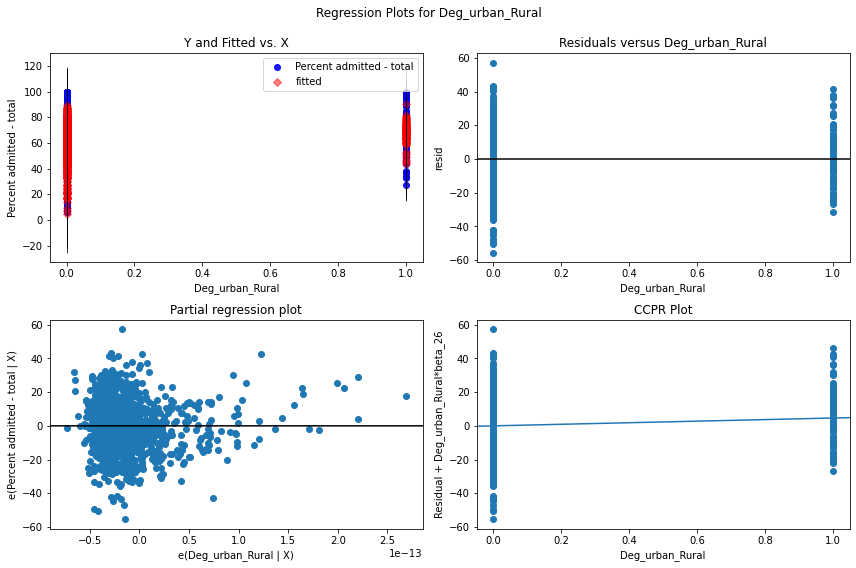

In [45]:
# check residual plots for each predictor
# applicants total, undergrad enrollment, financial aid vary w residuals - shouldn't use linear regression
for col in df.columns:
    if col == "Percent admitted - total":
        continue
    fig = plt.figure(figsize=(12,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()